# Outflows from a piece of the galactic disk

## Hydrodynamics
The equations of hydrodynamics are
\begin{align}
\partial_t \rho + \mathbf{\nabla} \cdot [\rho\,\mathbf{v}] & = 0 \\
\partial_t \rho\,\mathbf{v} + \mathbf{\nabla} \cdot [\rho\, \mathbf{v}\otimes\mathbf{v} + P \mathsf{I}] & = \rho\, \mathbf{g} \\
\partial_t E + \mathbf{\nabla} \cdot [(E + P)\, \mathbf{v}] & = \rho\, \mathbf{v} \cdot \mathbf{g} \,,
\end{align}
where $\rho$ is density, $\mathbf{v}$ is velocity, $P$ is pressure, and $E$ is the total energy density, and $\mathbf{g}$ is the gravitational acceleration from an external gravitational field. $E = \rho e + {1 \over 2} \rho v^2$, and $e$ is the internal energy per mass. This is complemented by an equation of state $P = (\gamma - 1)\rho e$.

This can also be written in the Lagranian form
\begin{align}
\partial_t \rho & = - \mathbf{v} \cdot \mathbf{\nabla} \rho
- \rho \mathbf{\nabla} \cdot \mathbf{v} \\
\partial_t \mathbf{v} & = - (\mathbf{v} \cdot \mathbf{\nabla}) \mathbf{v}
- \frac{1}{\rho} \mathbf{\nabla} P + \mathbf{g} \\
\partial_t P &= - \mathbf{v} \cdot \mathbf{\nabla} P
- \gamma P \mathbf{\nabla} \cdot \mathbf{v}\,,
\end{align}
where the advective derivative ($-\mathbf{v} \cdot \mathbf{\nabla}$) is explicit.

### Standard libaries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
np.seterr(all='raise',under='ignore'); # this option makes the code crash if encountering divide-by-zero, overflow or other floating point errors, but ignores underflow

In [2]:
# Blast waves and Riemann solver
def blast_wave(u,e0=1e4,d0=0.001,power=2,w=3.,verbose=True):
    """ Add a blastwave to a data set """
    #To get the placement of the SN I use np.random.choice, to choose an x with flat probability, and y with a probability that depends on the density profile
    x=np.random.choice(a=np.arange(-len(u.x)//2,len(u.x)//2,1))
    y=np.random.choice(np.arange(-len(u.y)//2,len(u.y)//2,1), p=np.exp(-0.5 * (u.y / u.Hgas)**2)/np.sum(np.exp(-0.5 * (u.y / u.Hgas)**2)))
    # I then roll u.r the amount that was chosen to give a new r that I can then use
    r=np.roll(np.roll(u.r, x, axis=0), y, axis=1)
    u.rho  += d0*np.exp(-(r/(w*u.ds))**power)
    u.Etot += e0*np.exp(-(r/(w*u.ds))**power)
    if verbose:
        m_add=np.sum(np.exp(-(u.r/(w*u.ds))**2))*u.ds**3*d0
        E_add=np.sum(np.exp(-(u.r/(w*u.ds))**2))*u.ds**3*e0*1.902e36
        print(f'Added supernova with mass: {m_add} solar masses, log(energy J): {np.log10(E_add)}: d0: {d0}, e0: {e0}')

def blast_wave_units(u,E=1e44,mass=10,power=2,w=3.,verbose=True):
    """ Add a blastwave with units of J for the energy and M_sun for mass"""
    mass
    E0=E/1.902e36
   # volume of profile so that everything becomes density
    norm=np.sum(np.exp(-(u.r/(w*u.ds))**2))*u.ds**3
    e0=E0/norm #energy density
    d0=mass/norm
    #To get the placement of the SN I use np.random.choice, to choose an x with flat probability, and y with a probability that depends on the density profile
    x=np.random.choice(a=np.arange(-len(u.x)//2,len(u.x)//2,1))
    y=np.random.choice(np.arange(-len(u.y)//2,len(u.y)//2,1), p=np.exp(-0.5 * (u.y /(0.5*u.Hgas))**2)/np.sum(np.exp(-0.5 * (u.y / (0.5*u.Hgas))**2)))
    # I then roll u.r the amount that was chosen to give a new r that I can then use
    r=np.roll(np.roll(u.r, x, axis=0), y, axis=1)
    u.rho  += d0*np.exp(-(r/(w*u.ds))**power)
    u.Etot += e0*np.exp(-(r/(w*u.ds))**power)
    if verbose or verbose==2:
        print(f'Added supernova with mass: {mass} solar masses, log(energy J): {np.log10(E)}: d0: {d0}, e0: {e0}, at time {u.t}')

# Conservative variables computed from primitve variable
def primitive_to_conservative(q):
    U = void()
    U.D  = q.D
    U.mU = q.D*q.U
    U.mV = q.D*q.V
    U.Etot = q.P / (q.gamma-1.0) + 0.5*q.D*(q.U**2 + q.V**2)
    return U

# Hydro flux from conservative and primitive variables
def Hydro_Flux(q,U):
    F = void()
    F.D = U.mU
    F.mU = U.mU*q.U + q.P
    F.mV = U.mV*q.U
    F.Etot = q.U*(U.Etot + q.P)
    return F

def HLL(ql,qr):
    # The first part is the same as for LLF, so just use copy & paste to fill that in:
    # sound speed for each side of interface (l==left, r==right)
    if np.any(ql.P<0):
        print('Pl<0')
    if np.any(ql.D<0):
        print('D_L<0')
        ql.D=np.where(ql.D<0,1e-15, ql.D)
    if np.any(qr.P<0):
        print('Pr<0')
    if np.any(qr.D<0):
        print('D_r<0')
        qr.D=np.where(qr.D<0,1e-15, qr.D)#stability
    c_left  = np.sqrt(ql.gamma*ql.P / ql.D)
    c_right = np.sqrt(qr.gamma*qr.P / qr.D)
    c_max = np.maximum(c_left,c_right)

    # maximum wave speeds to the left and right (guaranteed to have correct sign)
    SL = np.minimum(np.minimum(ql.U,qr.U)-c_max,0) # <= 0.
    SR = np.maximum(np.maximum(ql.U,qr.U)+c_max,0) # >= 0.
    
    # Hydro conservative variable
    Ul = primitive_to_conservative(ql)
    Ur = primitive_to_conservative(qr)

    # Hydro fluxes
    Fl = Hydro_Flux(ql,Ul)
    Fr = Hydro_Flux(qr,Ur)

    # HLL flux based on wavespeeds.  The general form is 
    #    (SR*F_left - SL*F_right + SL*SR *(u_right - u_left))/(SR-SL)
    # where U = (rho, rho*v, E_tot) are the conserved variables
    Flux = void()
    Flux.D  = (SR*Fl.D  - SL*Fr.D  + SL*SR*(Ur.D  - Ul.D )) / (SR - SL)
    Flux.mU = (SR*Fl.mU - SL*Fr.mU + SL*SR*(Ur.mU - Ul.mU)) / (SR - SL)
    Flux.mV = (SR*Fl.mV - SL*Fr.mV + SL*SR*(Ur.mV - Ul.mV)) / (SR - SL)
    Flux.Etot = (SR*Fl.Etot - SL*Fr.Etot + SL*SR*(Ur.Etot - Ul.Etot)) / (SR - SL)

    return Flux

## Using a Python class to store things
We start by defining a class `hd`, with things we will need for 2-D hydrodynamics.

In [22]:
class void():
    """ Empty class, used to create ad hoc objects """
    pass

class hd():
    """ Template class for hydrodynamics, with parameters, variables and methods
     Extended to work with elongated box"""
    def __init__(self,n=64,ratio=2, gamma=1.4,Lbox=1.):
        """ Initialization of arrays for conservative variables """
        self.t=0
        nx=n
        ny=ratio*n
        self.nx=nx
        self.ny=ny
        self.gamma = gamma
        self.rho   = np.ones((nx,ny))
        self.Etot  = np.ones((nx,ny))
        self.Px    = np.zeros((nx,ny))
        self.Py    = np.zeros((nx,ny))
        self.coordinates(Lbox=Lbox)
    
    def coordinates(self,Lbox=1., ratio=2):
        """ Coordinate initialization """
        nx = self.nx
        ny = self.ny
        self.ds = Lbox/nx
        self.dx = self.ds
        self.Lbox_x = nx*self.ds # Make sure n, ds, and Lbox correspond exactly to roundoff
        self.Lbox_y = ny*self.ds
        self.x = self.ds*(np.arange(nx)-nx/2+0.5)
        self.y = self.ds*(np.arange(ny)-ny/2+0.5)
        self.r = np.zeros((nx,ny))
        for i in range(nx):
            self.r[i] = (self.y**2 + self.x[i]**2)**0.5

    def velocity(self):
        """ Compute velocity from conservative variables and return in (2,n,n) array """
        return np.array([self.Px/self.rho, self.Py/self.rho])

    def pressure(self):
        """ Compute pressure from conservative variables """
        if (self.gamma==1.0):
            P = self.cs**2 * self.rho
        else:
            Eint = self.Etot - 0.5*(self.Px**2 + self.Py**2)/self.rho 
            P = (self.gamma-1.)*Eint
        return P

    def temperature(self, cgs=False):
        """ Compute the 'temperature', defined as P/rho = kB / mu T """          
        return self.pressure() / self.rho
    
    
    def temperature_cgs(self):
        """ Compute the temperature in K, defined as P/rho = kB / mu T """
        kb=1.381e-16 #(erg/K) in cgs
        rho=40.4768962*self.rho #proton mass pr cm^3
        mu=0.615 #average mass*proton mass
        P=self.pressure()*6.47316519e-13 #barye (cgs bar)
        T=P*mu/(kb*rho)
        return T
    
    def temperature_CGS(self):
        '''Compute the temperature in CGS'''
        k_b=1.381e-16   #Boltzman Constant in CGS
        n_cgs=self.rho*40.4768962  # Density in proton_masses/cm^3 
        mu=0.615 #Greek letter mu, dimensionless
        n_cgs=n_cgs/mu # numerical density in particles/ cm^3 ( CGS)
        P=self.pressure()*6.47316519e-13 #Pressure in CGS
        '''P=n/mu k_b T'''
        Temperature=P/(k_b*n_cgs) #Temperature in CGS
        return Temperature
    
    def number_density_CGS(self):
        '''Compute the number density in CGS'''
        n_cgs=self.rho*40.4768962  # Density in proton_masses/cm^3 
        mu=0.615 #Greek letter mu, dimensionless
        n_cgs=n_cgs/mu # numerical density in particles/ cm^3 ( CGS)
        return n_cgs

    
    def Courant(self,C=0.5):
        """ Courant condition for HD """
        v = self.velocity()
        speed = np.sqrt(v[0]**2 + v[1]**2)
        cs = np.sqrt(self.gamma*self.pressure()/self.rho)
        return C*self.ds/np.max(cs+speed)

def initial_condition(Lbox=1000, n=128, ratio=3, R0 = 8000, sigma_gas=100, Mvir=1.3e12, h=0.68):
    ratio=int(ratio)
    """Extended to elongated box"""
    # Lbox is the shortest size in pc
    # n is the numerical resolution in grid poins for the smallest axis
    # R0 is the radial distance from the center of the galaxy of the box in parsec
    # sigma_gas is in units of M_sun / pc^2
    # Mvir is the virial mass in the galaxy. 1.3 10^12 Msun is relevant for the Milky Way
    # h is the Hubble constant in units of 100 km s^-1 Mpc^-1
    
    # Basic unit system is u_M = Msun, u_l = 1 pc, u_t = 1 Myr
    kms_to_uv = 0.977813106 # (pc/Myr) / (km/s)
    
    # concentration parameter and virial radius
    c = 10**(1.025 - 0.097*np.log10(Mvir * h / 1e12))
    rho_crit = 2.7744948e-7 * h**2         # M_sun pc^-3
    rho0 = 200. * rho_crit * c * (1+c)**2 # M_sun pc^-3
    Rvir = (Mvir*c**3 / (4*np.pi*rho0*(np.log(1+c) - c / (1+c))))**(1/3) # pc
    Rs   = Rvir / c
    
    # rotation frequency [Myr^-1]
    Gnewt = 4.49830999e-3 # Newtons constant of gravity in [pc^3 Msun^-1 Myr^-2] 
    Omega = np.sqrt( Gnewt * Mvir / (np.log(1+c) - c / (1+c)) * (np.log(1 + R0/Rs) - R0 / (R0 + Rs)) / R0**3 )
    
    # setup initial grid
    u = hd(n=n, ratio=ratio, gamma=5/3, Lbox=Lbox)
    
    # compute new density and energy profile
    Tini = 1e3
    cs = 11.585 * np.sqrt( Tini / 1e4 ) * kms_to_uv # sound speed [pc/Myr] for a fully ionized medium with mu = 0.615
    Hgas = cs / Omega
    
    u.g = np.zeros((u.nx,u.ny)) # array holding gravitational acceleration
    
    for iy,y in enumerate(u.y):
        u.rho[:,iy] = sigma_gas / (np.sqrt(2.*np.pi) * Hgas) * np.exp(-0.5 * (y / Hgas)**2) 
        u.g[:,iy] = - Omega**2 * y
        
    P = u.rho * cs**2
    u.Etot = P / (u.gamma - 1)
    
    u.Mvir = Mvir
    u.Rvir = Rvir
    u.rho0 = rho0
    u.c = c
    u.cs = cs
    u.Hgas = Hgas
    u.Omega = Omega
    u.cool=np.zeros(np.shape(u.g))
    return u

In [4]:
#same as u.temperature_cgs()
def T_units(u):
    kb=1.381e-16 #(erg/K) in cgs
    rho=40.4768962*u.rho #proton mass pr cm^3
    mu=0.615 #average mass*proton mass
    P=u.pressure()*6.47316519e-13 #barye (cgs bar)
    T=P*mu/(kb*rho)
    return T

In [5]:
# pressure floor so all gas is at 1000 K min
def PT_floor(q, T0=1000):
    kb=1.381e-16 #(erg/K) in cgs
    rho=40.4768962*q.D #proton mass pr cm^3
    mu=0.615 #average mass*proton mass
    P=T0*kb*rho/mu/6.47316519e-13 #return to code units
    return P

In [6]:
# pressure floor so all gas is at 1000 K min
def PT_flooru(u, T0=1000):
    kb=1.381e-16 #(erg/K) in cgs
    rho=40.4768962*u.rho #proton mass pr cm^3
    mu=0.615 #average mass*proton mass
    P=T0*kb*rho/mu/6.47316519e-13 #return to code units
    return P

## Riemann Solvers

Riemann solvers are used to compute the fluxes that pass mass, momentum, and energy from cell to cell.  When working in two dimensions, we need to treat the interfaces on all four sides of each cell, with differences between _left_ and _right_, and _bottom_ and _top_ controlling the changes of conserved quantities.

### HLL (Harten, Lax, van Leer) fluxes

### Slope limiter
Monotonized Central (MonCen) slope limiter.  In two dimensions, return the  slopes in both directions, with shape (2,n,n)

In [7]:
def left_slope(f,axis=0):
    return (f-np.roll(f,1,axis))

def MonCen(f):
    """ Monotonized central slope limiter """
    shape=np.insert(f.shape,0,f.ndim)
    slopes=np.zeros(shape)
    for i in range(f.ndim):
        ls=left_slope(f,axis=i)
        rs=np.roll(ls,-1,axis=i)
        cs=np.zeros(f.shape)
        w=np.where(ls*rs>0.0)
        cs[w]=2.0*ls[w]*rs[w]/(ls[w]+rs[w])
        slopes[i]=cs
    return slopes

def MinMod(f):
    shape=np.insert(f.shape,0,f.ndim)
    slopes=np.zeros(shape)
    for i in range(f.ndim):
        ls=left_slope(f,axis=i)
        rs=np.roll(ls,-1,axis=i)
        cs=np.zeros(f.shape)
        sign=np.ones(ls.shape)
        sign[np.where(ls<0.)]-=1.0
        sign[np.where(rs<0.)]-=1.0
    return np.minimum(np.abs(ls),np.abs(rs))*sign

def Mix(f):
    mc=MonCen(f)
    mm=MinMod(f)
    return (mc+mm)/2

### MUSCL method
This is the core routine for solving hydrodynamics in one timestep. In the routine we have six steps:
  * 0) + 7) (operator split) source term for external gravitational potential add before and after the hydro fluxes to make it second order
  * 1) Primitive variables from conserved variables
  * 2) Slopes used for interpolation from cell center to cell interface and for time prediction
  * 3) Forward trace in time to find solution at t + dt/2
  * 4) + 5) Construction of "Left" and "Right" states for the cell interfaces
  * 6) Call to Riemann solver (HLL) to compute the fluxes for hydrodynamics and update of conserved variables

In [32]:
import sys
sys.setrecursionlimit(int(1e5))

def heating(beta=1e-24,F=0.01,G=5):
    return beta*F*G

def effective_cooling(nH, T, Eint, dt, threshold=0.3, sub=0):
    # nH: 1D vector of number densities [cm^-3]
    # T: 1D vector of temperature [K]
    # Eint: 1D vector of internal energy [code units]
    # dt: timestep [code units]
    u_cool = 2.05126608e-26 # 1 solar mass * (1 pc / 1e6 yr)^2 / (1 pc)^3 / 1e6 yr in (1 erg / s / cm^3)
    lamb=[]
    for t in T:
        lamb.append(cooling(t))
    lamb=np.array(lamb)
#     u.Lambda=lamb
    cool=lamb*nH**2
#     u.Q_cool=cool
    heat = heating() * nH
#     u.Q_heat=heat
#     u.Q=u.Q_heat-u.Q_cool
    dE = dt*(cool - heat) / u_cool
#     print(np.max(dE), np.min(dE))# (negative) change in internal energy in code units
    subcycling = sub + 1 # diagnostic, to track how many levels of recursion we have done
    # test if any cells change by a larger amount than threshold
    if np.any(np.abs(dE) > threshold*Eint):
        # extract indices of the cells that have changed more than threshold 
        idx = np.nonzero(np.abs(dE) > threshold*Eint)
        # store new 1D vector of cells
        nHi = np.copy(nH[idx])
        Ti = np.copy(T[idx])
        Einti = np.copy(Eint[idx])
        # reduce timestep
        dti = 0.25*dt
        # recursive calls with smaller timestep
        dEi, sub1 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Ti = Ti * (Einti - dEi) / Einti 
        Einti -= dEi
        dEi, sub2 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Ti = Ti * (Einti - dEi) / Einti 
        Einti -= dEi
        dEi, sub3 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Ti = Ti * (Einti - dEi) / Einti 
        Einti -= dEi
        dEi, sub4 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Einti -= dEi
        dE[idx] = Eint[idx] - Einti
        subcycling = max(sub1, sub2, sub3, sub4) # take max since different substeps may have recursed differently
    return dE, subcycling

def Source_cooling(u):
    """ Add cooling / heating here """
        # Calculate Temperature in CGS
    Temperature=u.temperature_CGS()
    T=Temperature.flatten()
    
    # Calculate Number Density in CGS
    n_cgs=u.number_density_CGS()
    n=n_cgs.flatten()
    
    Eint=np.array(u.pressure()/(u.gamma-1.)).flatten()
    
    dE, sub = effective_cooling(n, T, Eint, u.dt)
    # dE is on return a 1D array. Reshape it in to a 2D array
    dE=np.reshape(dE,np.shape(u.Etot))
    if sub > 5:
        print("Subcycling :", sub, u.dt / sub)
    u.Etot -= dE
    u.cool=-dE

# def Source_cooling(u):
#     """ Add cooling / heating here """
#     kb=1.381e-16 #(erg/K) in cgs
#     rho=40.4768962*u.rho#proton mass pr cm^3 
#     mu=0.615 #average proton mass per particle
#     P=u.pressure()*6.47316519e-13 #barye (cgs bar)
#     T=P*mu/(kb*rho)
#     n=rho/(mu*1)# compute number density in cm^-3 and make it in to a 1D array
#     Eint=u.Etot# compute temperature in Kelvin and make it in to a 1D array
#     lamb=cooling_DR_grid(T)
#     n=rho/(mu*1) 
#     Q_cool=n**2*lamb-n*heating() #this should be in erg/s/cm^3=barye/s
#     factor=4.871661429783992e25
#     Q_cool*=factor
#     k=10000
#     u.Etot-=Q_cool*u.dt/k
#     u.cool=Q_cool*u.dt/k
# #     u.floor_T()
# #     if u.t>10:
# #         print(np.max(Q_cool*u.dt),np.min(Q_cool*u.dt), np.max(u.Etot))
#     # compute temperature in physical units using mu=0.615 and that units of P/rho are (length / time)^2
#     # compute number density n in cm^3 (again, using mu=0.615)
#     # compute Lambda, the cooling rate per collision using spliced powerlaws below [units are erg cm^3]
#     # compute the volume cooling rate Q_cool [erg cm^-3*s^-1] = n^2 Lambda
#     # convert to numerical units
#     # change the total energy u.Etot -= Q_cool * u.dt
#     # Apply a cooling floor (Heating). Nothing can be below e.g. 1000 K
#     # Optional: Add photo-electric heating (proportional to n. Q_heat = heat * n)
    
def Source(u):
    """ Add contribution from gravitation with 1/2*dt
        The gravitaitonal acceleration is time independent
        and stored in the variable u.g.
        S(E_tot) = rho vy * g
        S(rho vy) = rho g
    """
    u.Etot += 0.5*u.dtds*u.Py*u.g
    u.Py   += 0.5*u.dtds*u.rho*u.g

def muscl_2d (u, dt, do_grav=True, do_cooling=False):
    u.dtds = dt/u.ds
    u.dt = dt
    if do_cooling:
        Slope=MinMod
    else:
        Slope=Mix
#     Slope=MonCen
    Riemann_Solver=HLL

    # 0) Add gravity 
    if do_grav:
        Source(u)                          # Add 1/2 source term at time t
    
    # 1) Compute primitive variables (rho, v, P)
    # make sure to copy u.rho to D, otherwise D becomes a "pointer" to u.rho, and updates itself in 5)
    if np.any(u.rho<0):
        print('rho rho')
        u.rho=np.where(u.rho<0,1e-15, u.rho)
    D = np.copy(u.rho)         # D: density
    v = u.velocity()           # v: velocity
    P = u.pressure()           # P: pressure
    if np.any(P<0):
        print('Pressure below 0')
        P_new=PT_floor(u)
        u.Etot=np.where(u.P<0,P_new/(u.gamma-1)+u.Etot, u.Etot)
        P = u.pressure()
    # 2) Compute slopes based on centered points
    dD = Slope(D)              # returns (2,n,n)
    dP = Slope(P)              # returns (2,n,n)
    dv0 = Slope(v[0])          # returns (2,n,n)
    dv1 = Slope(v[1])          # returns (2,n,n)
    dv = np.array([dv0,dv1])   # shape = (2,2,n,n)

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    # Time evolution with source terms
    div = dv[0,0] + dv[1,1]                  # div(v)
    D_t = - v[0]*dD[0] -v[1]*dD[1] - D*div   # dD/dt = -v*grad(D) - D*div(v)
    P_t = - v[0]*dP[0] -v[1]*dP[1] - u.gamma*P*div   # dP/dt = -v*grad(P) - gamma*P*div(v)
    v_t = np.copy(v)                         # shape = (2,n,n)
    v_t[0] = - v[0]*dv[0,0] - v[1]*dv[0,1] - dP[0]/D  # dv/dt = -v*grad(v) - grad(P)/D
    v_t[1] = - v[0]*dv[1,0] - v[1]*dv[1,1] - dP[1]/D
    if do_grav:
        v_t[1] += u.g*u.ds # have to add ds because slopes are differences without ds
    # Loop over X- and Y-direction
    for axis in range(2):
        ql = void(); ql.gamma = u.gamma
        qr = void(); qr.gamma = u.gamma
        
        # Calculates the parallel and perpendicular velocities to the coordinate direction
        # X-axis: iu=0, iv=1, Y-axis: iu=1, iv=0
        iu = axis
        iv = (axis + 1) % 2
        # Parallel (U) and perpendicular (V) velocities
        U = v[iu]; dU = dv[iu]; U_t = v_t[iu]
        V = v[iv]; dV = dv[iv]; V_t = v_t[iv]

        # 4) Spatial interpolation "axis"-direction + time terms

        # left state -- AS SEEN FROM THE INTERFACE
        ql.D = D + 0.5*dD[axis] + 0.5*u.dtds*D_t
        ql.P = P + 0.5*dP[axis] + 0.5*u.dtds*P_t
        ql.U = U + 0.5*dU[axis] + 0.5*u.dtds*U_t
        ql.V = V + 0.5*dV[axis] + 0.5*u.dtds*V_t
        #cooling floor
        step=0
        while np.any(ql.P<0):
            print('P left below 0. Backstep')
            ql.P = P + 0.25/(step+1)*dP[axis] + 0.25/(step+1)*u.dtds*P_t
            step+1
        step=0
        while np.any(ql.D<0):
            print('D left below 0. Backstep')
            ql.D = D + 0.25/(step+1)*dD[axis] + 0.25/(step+1)*u.dtds*D_t
            step+1
        # right state -- AS SEEN FROM THE INTERFACE
        qr.D = D - 0.5*dD[axis] + 0.5*u.dtds*D_t
        qr.P = P - 0.5*dP[axis] + 0.5*u.dtds*P_t
        qr.U = U - 0.5*dU[axis] + 0.5*u.dtds*U_t
        qr.V = V - 0.5*dV[axis] + 0.5*u.dtds*V_t
        step=0
        while np.any(qr.P<0):
            print('P left below 0. Backstep')
            qr.P = P - 0.25/(step+1)*dP[axis] + 0.25/(step+1)*u.dtds*P_t
            step+1
        step=0
        while np.any(qr.D<0):
            print('P left below 0. Backstep')
            qr.D = D - 0.25/(step+1)*dD[axis] + 0.25/(step+1)*u.dtds*D_t
            step+1
        #cooling floor
            
        # 5) Roll down -1 in the "axis" direction so that we collect
        #    left and right state (as seen from the interface) at the same grid index
        qr.D = np.roll(qr.D,-1,axis=axis)
        qr.P = np.roll(qr.P,-1,axis=axis)
        qr.U = np.roll(qr.U,-1,axis=axis)
        qr.V = np.roll(qr.V,-1,axis=axis)
        # 6) Solve for flux based on interface values
        Flux = Riemann_Solver(ql,qr)

        # Update conserved variables with fluxes
        u.rho  -= u.dtds * (Flux.D - np.roll(Flux.D,1,axis=axis))
        u.Etot -= u.dtds * (Flux.Etot - np.roll(Flux.Etot,1,axis=axis))
        if axis==0: # X-axis
            u.Px   -= u.dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))
            u.Py   -= u.dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
        if axis==1: # Y-axis
            u.Px   -= u.dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
            u.Py   -= u.dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))
#stability
    # 7) Add gravity 
    if do_grav:
        Source(u)                          # Add 1/2 source term at t + dt
    
    # 8) Here you could add cooling and heating. Since cooling can be
    # stiff -- e.g. immediately forcing the gas to a certain
    # temperature -- it is best to do the full heating / cooling contribution
    # at the end of a timestep
    
    if do_cooling:
        Source_cooling(u)
    
    return u

In [34]:
def effective_cooling(nH, T, Eint, dt, threshold=0.3, sub=0):
    # nH: 1D vector of number densities [cm^-3]
    # T: 1D vector of temperature [K]
    # Eint: 1D vector of internal energy [code units]
    # dt: timestep [code units]
    u_cool = 2.05126608e-26 # 1 solar mass * (1 pc / 1e6 yr)^2 / (1 pc)^3 / 1e6 yr in (1 erg / s / cm^3)
    lamb=[]
    for t in T:
        lamb.append(cooling(t))
    lamb=np.array(lamb)
#     u.Lambda=lamb
    cool=lamb*nH**2
#     u.Q_cool=cool
    heat = heating() * nH
#     u.Q_heat=heat
#     u.Q=u.Q_heat-u.Q_cool
    dE = dt*(cool - heat) / u_cool
#     print(np.max(dE), np.min(dE))# (negative) change in internal energy in code units
    subcycling = sub + 1 # diagnostic, to track how many levels of recursion we have done
    # test if any cells change by a larger amount than threshold
    if np.any(np.abs(dE) > threshold*Eint):
        # extract indices of the cells that have changed more than threshold 
        idx = np.nonzero(np.abs(dE) > threshold*Eint)
        # store new 1D vector of cells
        nHi = np.copy(nH[idx])
        Ti = np.copy(T[idx])
        Einti = np.copy(Eint[idx])
        # reduce timestep
        dti = 0.25*dt
        # recursive calls with smaller timestep
        dEi, sub1 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Ti = Ti * (Einti - dEi) / Einti 
        Einti -= dEi
        dEi, sub2 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Ti = Ti * (Einti - dEi) / Einti 
        Einti -= dEi
        dEi, sub3 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Ti = Ti * (Einti - dEi) / Einti 
        Einti -= dEi
        dEi, sub4 = effective_cooling(nHi, Ti, Einti, dti, threshold=threshold, sub=subcycling)
        Einti -= dEi
        dE[idx] = Eint[idx] - Einti
        subcycling = max(sub1, sub2, sub3, sub4) # take max since different substeps may have recursed differently
    return dE, subcycling

def Source_cooling(u):
    """ Add cooling / heating here """
        # Calculate Temperature in CGS
    Temperature=u.temperature_CGS()
    T=Temperature.flatten()
    
    # Calculate Number Density in CGS
    n_cgs=u.number_density_CGS()
    n=n_cgs.flatten()
    
    Eint=np.array(u.pressure()/(u.gamma-1.)).flatten()
    
    dE, sub = effective_cooling(n, T, Eint, u.dt)
    # dE is on return a 1D array. Reshape it in to a 2D array
    dE=np.reshape(dE,np.shape(u.Etot))
    if sub > 5:
        print("Subcycling :", sub, u.dt / sub)
    u.Etot -= dE
    u.cool=-dE
    
def Source(u):
    """ Add contribution from gravitation with 1/2*dt
        The gravitaitonal acceleration is time independent
        and stored in the variable u.g.
        S(E_tot) = rho vy * g
        S(rho vy) = rho g
    """
    u.Etot += 0.5*u.dtds*u.Py*u.g
    u.Py   += 0.5*u.dtds*u.rho*u.g

def muscl_2d (u, dt, do_grav=True,do_cooling=False):
    u.dtds = dt/u.ds
    u.dt = dt
    Slope=MinMod
    Riemann_Solver=HLL

    # 0) Add gravity 
    if do_grav:
        Source(u)                          # Add 1/2 source term at time t
    
    # 1) Compute primitive variables (rho, v, P)
    # make sure to copy u.rho to D, otherwise D becomes a "pointer" to u.rho, and updates itself in 5)
    D = np.copy(u.rho)         # D: density
    v = u.velocity()           # v: velocity
    P = u.pressure()           # P: pressure
    

    # 2) Compute slopes based on centered points
    dD = Slope(D)              # returns (2,n,n)
    dP = Slope(P)              # returns (2,n,n)
    dv0 = Slope(v[0])          # returns (2,n,n)
    dv1 = Slope(v[1])          # returns (2,n,n)
    dv = np.array([dv0,dv1])   # shape = (2,2,n,n)

    # 3) Trace forward to find solution at [t+dt/2, x +- dx/2]
    # Time evolution with source terms
    div = dv[0,0] + dv[1,1]                  # div(v)
    D_t = - v[0]*dD[0] -v[1]*dD[1] - D*div   # dD/dt = -v*grad(D) - D*div(v)
    P_t = - v[0]*dP[0] -v[1]*dP[1] - u.gamma*P*div   # dP/dt = -v*grad(P) - gamma*P*div(v)
    v_t = np.copy(v)                         # shape = (2,n,n)
    v_t[0] = - v[0]*dv[0,0] - v[1]*dv[0,1] - dP[0]/D  # dv/dt = -v*grad(v) - grad(P)/D
    v_t[1] = - v[0]*dv[1,0] - v[1]*dv[1,1] - dP[1]/D
    if do_grav:
        v_t[1] += u.g*u.ds # have to add ds because slopes are differences without ds
    
    # Loop over X- and Y-direction
    for axis in range(2):
        ql = void(); ql.gamma = u.gamma
        qr = void(); qr.gamma = u.gamma
        
        # Calculates the parallel and perpendicular velocities to the coordinate direction
        # X-axis: iu=0, iv=1, Y-axis: iu=1, iv=0
        iu = axis
        iv = (axis + 1) % 2
        # Parallel (U) and perpendicular (V) velocities
        U = v[iu]; dU = dv[iu]; U_t = v_t[iu]
        V = v[iv]; dV = dv[iv]; V_t = v_t[iv]

        # 4) Spatial interpolation "axis"-direction + time terms

        # left state -- AS SEEN FROM THE INTERFACE
        ql.D = D + 0.5*dD[axis] + 0.5*u.dtds*D_t
        ql.P = P + 0.5*dP[axis] + 0.5*u.dtds*P_t
        ql.U = U + 0.5*dU[axis] + 0.5*u.dtds*U_t
        ql.V = V + 0.5*dV[axis] + 0.5*u.dtds*V_t
        
        
        

        # right state -- AS SEEN FROM THE INTERFACE
        qr.D = D - 0.5*dD[axis] + 0.5*u.dtds*D_t
        qr.P = P - 0.5*dP[axis] + 0.5*u.dtds*P_t
        qr.U = U - 0.5*dU[axis] + 0.5*u.dtds*U_t
        qr.V = V - 0.5*dV[axis] + 0.5*u.dtds*V_t

        
        
        
        # 5) Roll down -1 in the "axis" direction so that we collect
        #    left and right state (as seen from the interface) at the same grid index
        qr.D = np.roll(qr.D,-1,axis=axis)
        qr.P = np.roll(qr.P,-1,axis=axis)
        qr.U = np.roll(qr.U,-1,axis=axis)
        qr.V = np.roll(qr.V,-1,axis=axis)

        # 6) Solve for flux based on interface values
        Flux = Riemann_Solver(ql,qr)

        # Update conserved variables with fluxes
        u.rho  -= u.dtds * (Flux.D - np.roll(Flux.D,1,axis=axis))
        u.Etot -= u.dtds * (Flux.Etot - np.roll(Flux.Etot,1,axis=axis))
        if axis==0: # X-axis
            u.Px   -= u.dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))
            u.Py   -= u.dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
        if axis==1: # Y-axis
            u.Px   -= u.dtds * (Flux.mV - np.roll(Flux.mV,1,axis=axis))
            u.Py   -= u.dtds * (Flux.mU - np.roll(Flux.mU,1,axis=axis))

    # 7) Add gravity 
    if do_grav:
        Source(u)                          # Add 1/2 source term at t + dt
    
    # 8) Here you could add cooling and heating. Since cooling can be
    # stiff -- e.g. immediately forcing the gas to a certain
    # temperature -- it is best to do the full heating / cooling contribution
    # at the end of a timestep
    
    if do_cooling:
        Source_cooling(u)
    
    return u

In [10]:
# Cooling function given a single temperature
def cooling(temp):
# Fit to cooling profile, merged between Dalgarno & McCray(1972)
# for low temp, and Raymond, Cox & Smith(1976) for high temp.
    TE1=1000.0 # I have changed this from 10 to 1000 to provide a cooling floor
    TE2=2000.0
    TE3=8000.0
    TE4=2.5e4
    TE5=1.0e5
    TE6=2.5e5
    TE7=4.0e5
    TE8=4.5e7
    C1=2.0
    C2=1.5
    C3=5.0
    C4=0.83
    C5=0.0
    C6=-2.54
    C7=-0.49
    C8=0.5
    H1=8.00e15
    H2=3.58e17
    H3=7.79e03
    H4=1.70e22
    H5=2.38e26
    H6=1.22e20
    H7=4.00e28
    H8=1.07e21

    if temp <= TE1:
        qq=0.
    elif temp <= TE2:
        qq=H1*temp**C1
    elif temp <= TE3:
        qq=H2*temp**C2
    elif temp <= TE4:
        qq=H3*temp**C3
    elif temp <= TE5:
        qq=H4*temp**C4
    elif temp <= TE6:
        qq=H5*temp**C5
    elif temp <= TE7:
        qq=H6*temp**C6*1e20
    elif temp <= TE8:
        qq=H7*temp**C7
    else:
        qq=H8*temp**C8

    cooling_Dalgarno=qq*4e-28*1e-20
    return cooling_Dalgarno

In [11]:
# Cooling function given a grid of temperatures
def cooling_grid(temp):
# Fit to cooling profile, merged between Dalgarno & McCray(1972)
# for low temp, and Raymond, Cox & Smith(1976) for high temp.
    qq=np.zeros(np.shape(temp))
    TE1=1000.0 # I have changed this from 10 to 1000 to provide a cooling floor
    TE2=2000.0
    TE3=8000.0
    TE4=2.5e4
    TE5=1.0e5
    TE6=2.5e5
    TE7=4.0e5
    TE8=4.5e7
    C1=2.0
    C2=1.5
    C3=5.0
    C4=0.83
    C5=0.0
    C6=-2.54
    C7=-0.49
    C8=0.5
    H1=8.00e15
    H2=3.58e17
    H3=7.79e03
    H4=1.70e22
    H5=2.38e26
    H6=1.22e20
    H7=4.00e28
    H8=1.07e21

    qq=np.where((TE1<=temp)&(temp<=TE2),H1*temp**C1,qq)
    qq=np.where((TE2<=temp)&(temp<=TE3),H2*temp**C2,qq)
    qq=np.where((TE3<=temp)&(temp<=TE4),H3*temp**C3,qq)
    qq=np.where((TE4<=temp)&(temp<=TE5),H4*temp**C4,qq)
    qq=np.where((TE5<=temp)&(temp<=TE6),H5*temp**C5,qq)
    qq=np.where((TE6<=temp)&(temp<=TE7),H6*temp**C6*1e20,qq)
    qq=np.where((TE7<=temp)&(temp<=TE8),H7*temp**C7,qq)
    qq=np.where(TE8<=temp, H8*temp**C8, qq)


    cooling_Dalgarno=qq*4e-28*1e-20
    return cooling_Dalgarno

# Plotting functions

In [12]:
# Plotting
def plotrhoT(u,size=15,x=None, log=True, title=True):
    if log:
        rho=np.maximum(np.log10(u.rho),-6)
    else:
        rho=u.rho
    T=np.log10(u.temperature_cgs())
    t=u.t
    fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(size,size))
    if x == None:
        rho=ax[0].imshow(np.transpose(rho),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
        T=ax[1].imshow(np.transpose(T),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    else:
        rho=ax[0].imshow(np.transpose(rho),origin='lower',extent=[-x,x,-x,x])
        T=ax[1].imshow(np.transpose(T),origin='lower',extent=[-x,x,-x,x])
    if title:
        t1=r'$\rho$ at time'+f' {t:.3f}'
        if log:
            t1=r'log($\rho$) at time'+f' {t:.3f}'
        t2='log(T) at time'+f' {t:.3f}'
    else:
        t1,t2=None, None
    ax[0].set(title=t1)
    ax[1].set(title=t2)
    fig.colorbar(rho, ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(T, ax=ax[1], fraction=0.046, pad=0.04)
    fig.tight_layout();

def imshow(f,size=10,x=None, title=None):
    plt.figure(figsize=(size,size))
    if x == None:
        plt.imshow(np.transpose(f),origin='lower')
    else:
        plt.imshow(np.transpose(f),origin='lower',extent=[-x,x,-x,x])
    plt.title(title)
    plt.colorbar();

def plotrhoTcool(u,size=15,x=None, title=True):
    rho=np.maximum(np.log10(u.rho),-7)
    T=np.log10(u.temperature_cgs())
    Q=u.cool/u.rho #energy/mass
    t=u.t
    fig, ax = plt.subplots(nrows=1,ncols=3, figsize=(size,size))
    if x == None:
        rho=ax[0].imshow(np.transpose(rho),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
        T=ax[1].imshow(np.transpose(T),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
        Q=ax[2].imshow(np.transpose(Q),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    else:
        rho=ax[0].imshow(np.transpose(rho),origin='lower',extent=[-x,x,-x,x])
        T=ax[1].imshow(np.transpose(T),origin='lower',extent=[-x,x,-x,x])
        Q=ax[2].imshow(np.transpose(Q),origin='lower',extent=[-x,x,-x,x])
    if title:
        t1=r'log($\rho$) at time'+f' {t:.3f}'
        t2='log(T) at time'+f' {t:.3f}'
        t3='dE per mass at time'+f' {t:.3f}: Positive is heating, negative is cooling'
    else:
        t1,t2,t3=None, None,None
    ax[0].set(title=t1)
    ax[1].set(title=t2)
    ax[2].set(title=t3)
    fig.colorbar(rho, ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(T, ax=ax[1], fraction=0.046, pad=0.04)
    fig.colorbar(Q, ax=ax[2], fraction=0.046, pad=0.04)
    fig.tight_layout();

In [13]:
def plotall(u,total_SN,mass,stars=None,size=20, title=True, scenario='MW', fs=18,x0=0.05):
    rho=np.maximum(np.log10(u.rho),-7)
    T=np.log10(u.temperature_cgs())
    Q=u.cool/u.rho #energy/mass
    if type(stars)==type(None):
        stars=np.zeros(np.shape(u.rho))
    starrho=np.maximum(np.log10(stars**4+u.rho/100),-4)
    py=u.Py
    t=u.t
    fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(size,size))
    ax=ax.flatten()
    rho=ax[0].imshow(np.transpose(rho),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    T=ax[1].imshow(np.transpose(T),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    Q=ax[2].imshow(np.transpose(Q),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    Py=ax[3].imshow(np.transpose(py),origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    starim=ax[4].imshow(np.transpose(starrho),cmap='magma', origin='lower',extent=[-np.abs(u.x[0]),np.abs(u.x[0]),-np.abs(u.y[0]),np.abs(u.y[0])])
    ax[5].annotate(f'Total mass lost {np.round(mass[0]-mass[-1],decimals=1)}', xy=(x0,0.9), xycoords='axes fraction', fontsize=fs)
    ax[5].annotate(f'Total mass {np.round(mass[-1], 1)}', xy=(x0,0.7), xycoords='axes fraction', fontsize=fs)
    ax[5].annotate(f'Total SN {total_SN}', xy=(x0,0.5), xycoords='axes fraction', fontsize=fs)
    ax[5].annotate(f'Total mass turned into stars {np.round(np.sum(stars), 2)}', xy=(x0,0.3), xycoords='axes fraction', fontsize=fs)
    if title:
        t1=r'log($\rho$) at time'+f' {t:.3f}'
        t2='log(T) at time'+f' {t:.3f}'
        t3='dE from heating/cooling per mass at time'+f' {t:.3f}'
        t4=r'$P_y$ at time'+f' {t:.3f}'
        t5=r'Stellar relative luminosity (using $L \propto M^4$) at time'+f' {t:.3f}'
    else:
        t1,t2,t3,t4,t5=None, None,None
    ax[0].set(title=t1)
    ax[1].set(title=t2)
    ax[2].set(title=t3)
    ax[3].set(title=t4)
    ax[4].set(title=t5)
    fig.colorbar(rho, ax=ax[0], fraction=0.046, pad=0.04)
    fig.colorbar(T, ax=ax[1], fraction=0.046, pad=0.04)
    fig.colorbar(Q, ax=ax[2], fraction=0.046, pad=0.04)
    fig.colorbar(Py, ax=ax[3], fraction=0.046, pad=0.04)
    fig.colorbar(starim, ax=ax[4], fraction=0.046, pad=0.04)
    fig.tight_layout();
    if scenario!=None:
        fig.savefig('figs/plotall/'+scenario+'.png')

In [14]:
def make_IMF(a=0.5,b=200):
    from scipy.stats import rv_continuous, rv_discrete
    class chabrier(rv_continuous):
        def _pdf(self,m):
            '''Note that the masses are in M_solar'''
            k=0.158*1/(np.log(10))*np.exp(-(np.log(1/0.08))**2/(2*0.69**2))
            return np.where(m<1, 0.158*1/(np.log(10)*m)*np.exp(-(np.log(m/0.08))**2/(2*0.69**2)), k*m**(-2.3))
    IMF=chabrier(a=a, b=b) 
    m=np.logspace(np.log10(a), np.log10(b), 100000)
    spec=IMF.pdf(m)
    spec=spec/np.sum(spec)
    return m,spec

In [15]:
def plot_SF(ts, n_stars, n_SN, it, scenario=None):
    fig, ax =plt.subplots(figsize=(8,5))
    ax.plot(ts[1:], n_stars,label='Total mass converted into stars')
    ax.plot(ts[1:], 10*n_SN[:it], label='Number of detonated SN * 10')
    ax.legend()
    if scenario!=None:
        fig.savefig('figs/star_formation/'+scenario+'.png')

In [16]:
def mass_lost(mass, time, scale='log', scenario='MW_nocool'):
    fig, ax=plt.subplots(nrows=1,ncols=3, figsize=(12,5))
    ax[0].plot(time[1:], -(mass[1:]-mass[:-1])/(time[1:]-time[:-1]), label='mass loss rate')
    ax[0].set(title='Mass lost pr timestep (M_solar/Myr)', xlabel='t[Myr]', ylabel='dM/dt [(M_solar/Myr)]', yscale=scale, ylim=(1e-6,None))
    ax[1].plot(time[1:], -(mass[1:]-mass[0]), label='Total mass loss')
    ax[1].set(title='Total mass lost', xlabel='t[Myr]', ylabel='M [M_solar]', yscale=scale, ylim=(1e-6,None))
    ax[2].plot(time[1:], (1-(mass[1:]/mass[0]))*100, label='fraction mass loss')
    ax[2].set(title='% mass lost from box', xlabel='t[Myr]', ylabel='%')
    ax[0].legend()
    ax[1].legend()
    fig.tight_layout()
    if scenario!=None:
        fig.savefig('figs/mass_loss/'+scenario+'.png')
    return mass[0]-mass[-1]

In [17]:
def momentum_flow(p_up,p_down, time, cut=1000, scale='log', scenario='MW_nocool'):
    fig, ax=plt.subplots(figsize=(8,5))
    p_up,p_down=np.array(p_up),np.array(p_down)
    p=p_up+p_down
    ax.plot(time, p_up, label='Mass flow upwards')
    ax.plot(time, p_down, label='Mass flow downwards')
    ax.plot(time, p, label=f'Mass flow away from the disk at a height of {u.y[cut]} pc')
    ax.set(title='Momentum', xlabel='t[Myr]', ylabel='P_y [M_solar*pc/Myr]', yscale=scale)
    ax.legend()
    if scenario!=None:
        fig.savefig('figs/momentum_flow/'+scenario+'.png')

# Model setup: a piece of a galactic disk

The physical setup is a 2 kpc piece of the galactic disk. We assume that initially the gas is in hydrostatic equilibrium and has an isothermal temperature of $T=10^3$ K. The initial condition can then be specified once we know the gravitational acceleration.

### Gravitational Potential
For simplicity, we assume that the gravitational acceleration is prescribed, and due to the Dark Matter halo, described by a NFW profile
\begin{equation}\tag{1}
\rho(R) = \frac{\rho_0}{{R\over R_s}\left(1 + {R \over R_s}\right)^2}
\end{equation}
Assuming that $z \ll R$ this leads to a vertical gravitational acceleration of:
\begin{equation}\tag{2}
g(z) = - \frac{G M_\textrm{vir}}{\ln(1+c) - {c \over 1+c}} \frac{\ln(1 + R / R_s) - R / ( R + R_s )}{R^2} \frac{z}{R}\,,
\end{equation}
where $g(z)$ is the vertical acceleration, $M_\textrm{vir}$ is the virial mass of the galaxy, $c = R_\textrm{vir} / R_s$ is the concentration parameter, $R_s$ the inner radius for the NFW profile, and $R$ is the radius of the piece of the galactic disk. Collecting constant factors, this can be simplified to the relation
\begin{equation}\tag{3}
g(z) = - \Omega^2 z \,,\quad \Omega^2 = \frac{G M_\textrm{vir}}{\ln(1+c) - {c \over 1+c}} \frac{\ln(1 + R / R_s) - R / ( R + R_s )}{R^3}\,,
\end{equation}
where we see that $\Omega$ is the rotation frequency at radius $R$.

### Virial Mass and Radius
The concentration parameter (and hence $R_s$) is related to the virial mass as \[Posti \& Helmi 2019\]:
\begin{equation}\tag{4}
\log_{10} c = 1.025 - 0.097 \log_{10} \left(\frac{M_\textrm{vir}}{10^{12} h^{-1} M_\odot}\right)\,,
\end{equation}
where $h=0.68$ is the Hubble parameter in units of 100 km s$^{-1}$ Mpc$^{-1}$. We use the common assumption that $\rho_\textrm{vir} = 200 \,\rho_\textrm{crit}$ is a good approximation for the virial density, where $\rho_\textrm{crit} = 3 H^2 / 8 \pi G = 1.878\,10^{-29} h^2$ g cm$^{-3} = 2.77\,10^{-7} h^2$ M$_\odot$ pc$^{-3}$ is the critical cosmological density. This allow us to derive the virial radius $R_\textrm{vir}$ from the virial mass of the galaxy by integrating eq (1) and using the relations between $c$, $R_s$, and $R_\textrm{vir}$ yielding
\begin{equation}
\rho_\textrm{vir} = 200 \rho_\textrm{crit} = \frac{\rho_0}{c(1+c)^2}
\end{equation}
\begin{equation}
M_\textrm{vir} = 4 \pi \int^{R_\textrm{vir}}_0 R^2 dR \rho(R) = 4 \pi \rho_0 c^{-3}\left[ \ln(1+c) - \frac{c}{c+1} \right] R_\textrm{vir}^3
\end{equation}


### Hydrostatic Equilibrium
The assumption of hydrostatic equilibrium in the vertical direction allow us to derive a pressure profile using
\begin{equation}
\frac{dP}{dz} = - \rho g(z) = - \rho \Omega^2 z 
\end{equation}
Adopting initially a constant temperature we have $P = c_s^2 \rho$, with the isothermal sound speed $c_s^2 = k_B T / \mu m_p$. This allow us to solve for the density as a function of height
\begin{equation}
\rho(z) = \frac{\Sigma}{\sqrt{2\pi} H_g}\exp\left[-{1\over 2}\left(\frac{z}{H_g}\right)^2\right]\,,
\end{equation}
where $H_g = c_s\, /\, \Omega$ is the scale height in the disk, and $\Sigma = \int dz\, \rho(z)$ is the surface density.

### Units
The natural units for the problem are
* Unit of mass: u_m = 1 solar mass
* Unit of length: u_l = 1 parsec
* Unit of time: u_t = 1 Myr

The relevant derived units are:
* Unit of velocity u_v = 1 pc / 1 Myr = 0.977813106 km/s
* Unit of density u_d = (solar mass / pc^3) = 6.7702543e-23 g / (cm^3) = 40.4768962 proton mass cm^-3
* Energy density u_e = u_m / u_l^3 * (u_l / u_t)^2 = 6.47316519e-13 barye
* Energy u_E = u_m (u_l / u_t)^2 = 1.90181525e36 J

### Initial conditions

### Testing the initial conditions

Central density: 0.037781560488512805
Scale height  : 125.94980611630628
1 / Omega     : 35.15973646241477
Virial radius : 129683.32734664268
Concentration parameter : 10.719983830625154
Total mass : 781250.0


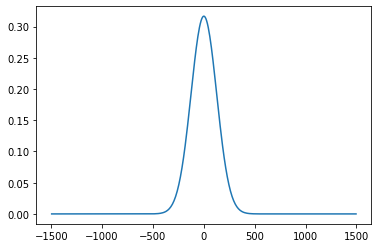

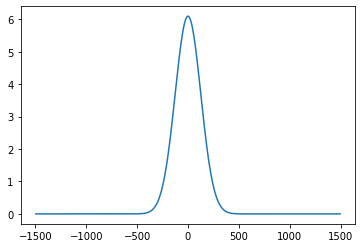

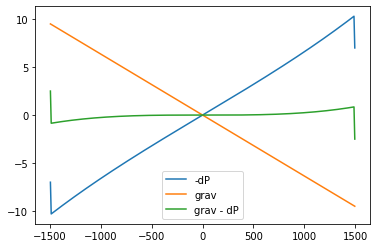

In [17]:
u = initial_condition(n=128)
print("Central density:", u.rho0)
print("Scale height  :", u.Hgas)
print("1 / Omega     :", 1. / u.Omega)
print("Virial radius :", u.Rvir)
print("Concentration parameter :", u.c)
print("Total mass :", np.sum(u.rho)*u.ds**3)
plt.figure()
plt.plot(u.y,u.rho[0])
plt.show()
plt.figure()
plt.plot(u.y,u.Etot[0])
plt.show()
plt.figure()
P = (u.pressure())[0]
dPdy = 0.5*(np.roll(P,-1) - np.roll(P,+1))/u.ds
plt.plot(u.y,-dPdy/u.rho[0]*u.ds,label='-dP')
plt.plot(u.y,u.g[0]*u.ds,label='grav')
plt.plot(u.y,(u.g[0] - dPdy/u.rho[0])*u.ds,label='grav - dP')
plt.legend();


Central density: 0.037781560488512805
Scale height  : 125.94980611630628
1 / Omega     : 35.15973646241477
Virial radius : 129683.32734664268
Concentration parameter : 10.719983830625154
Total mass : 781193.9605710978


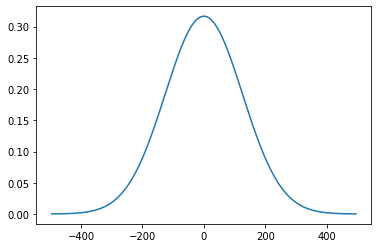

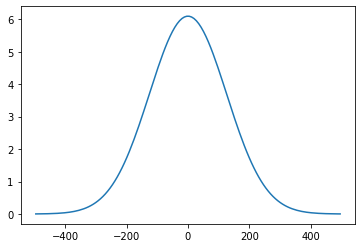

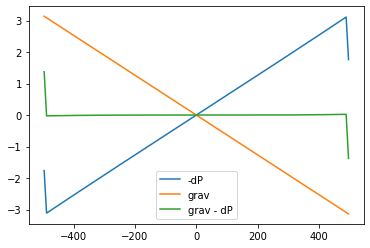

In [18]:
u = initial_condition(n=128, ratio=1)
print("Central density:", u.rho0)
print("Scale height  :", u.Hgas)
print("1 / Omega     :", 1. / u.Omega)
print("Virial radius :", u.Rvir)
print("Concentration parameter :", u.c)
print("Total mass :", np.sum(u.rho)*u.ds**3)
plt.figure()
plt.plot(u.y,u.rho[0])
plt.show()
plt.figure()
plt.plot(u.y,u.Etot[0])
plt.show()
plt.figure()
P = (u.pressure())[0]
dPdy = 0.5*(np.roll(P,-1) - np.roll(P,+1))/u.ds
plt.plot(u.y,-dPdy/u.rho[0]*u.ds,label='-dP')
plt.plot(u.y,u.g[0]*u.ds,label='grav')
plt.plot(u.y,(u.g[0] - dPdy/u.rho[0])*u.ds,label='grav - dP')
plt.legend();


### Blast wave function

\begin{equation}\tag{5}
f(r) = A \,e^{-\left(\frac{r}{w\Delta r}\right)^p}
\end{equation}

where $p$ is an exponent of order $2-4$, and $w$ controls the with in cell size ($\Delta r$) units.

In [19]:
run=0
if run:
    #No cooling
    Lbox = 2e3
    n = 32
    Cdt = 0.5
    nt = 100000
    totalSN=0
    u = initial_condition(n=n, Lbox=Lbox)
    u.rho_out = u.rho[0,0]
    u.P_out = (u.pressure())[0,0]
    start = time()
    it=0
    # plt.figure(figsize=(16,10))
    # plt.plot(u.y,u.rho[0],label='rho0')
    # plt.legend()
    # plt.title('Initial density configuration')
    dt_plot = 4
    t_plot = 0.
    dt_SN = 0.2
    t_SN = 0.
    imshow(np.log10(T_units(u)))
    print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
    while u.t < 20 and it < nt:
        dt=u.Courant(Cdt)
        u = muscl_2d(u,dt)
    # Boundary conditions at upper and lower end of box:
        rho_out_up =np.mean(u.rho[:,2:4])
        rho_out_down=np.mean(u.rho[:,-4:-2])
        P_out_up   =np.mean(u.pressure()[:,2:4])
        P_out_down = np.mean(u.pressure()[:,-4:-2])
        u.rho[:,0] = rho_out_up
        u.rho[:,-1] = rho_out_down
        u.Px[:,0] = u.Px[:,-1] = 0
        u.Py[:,0] = u.Py[:,-1] = 0
        u.Etot[:,0] =P_out_up / (u.gamma - 1.)
        u.Etot[:,-1] = P_out_down / (u.gamma - 1.)
        #plt.figure()
        if (u.t - t_plot > dt_plot):
            #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
            #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
            print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
            plotrhoT(u)
            t_plot += dt_plot
        if (u.t - t_SN > dt_SN):
    #         blast_wave(u,e0=1e4,d0=1,power=2,w=3.)
            blast_wave_units(u,E=1e44,mass=10, w=1)
            t_SN += dt_SN
            totalSN+=1
        u.t += dt
        it+=1
    plotrhoT(u)
    used=time()-start
    print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
    print("t={} nt={}".format(u.t,it))
    print(f"Total SNe detonated {totalSN}")

# Blast Wave in 2-D

Releasing a large amount of energy into a background fluid creates an explosion characterized by a strong shock wave, which then expands radially outwards from the point where the energy was released. In astrophysics, this happens, for example, in the case of supernovae. This is called a Sedov-Taylor blast wave. Sedov and Taylor first solved the problem in the context of atomic bomb explosions, but the solution is also useful in astrophysics. It can be used to test and validate hydrodynamical computer codes since an analytical solution exists. Blast waves are good candidates for adaptive mesh refinement (AMR) technique, that you read about in the book, but they can also be resolved with a uniform grid that we will use in the exam project. Add a function `blast_wave` that you can call in the time evolution loop. Use what you implemented in week 2, but update it to have a random position in $x$ and a position in $y$ that correlates with the disk height. Hint: a hydrostatic disk has a density profile which follows $\exp(-y^2/2H^2)$, this is a well known function for random variables. Remember that the box is periodic in the x-direction. Therefore a "radius function" for depositing energy and mass should also be periodic in that direction. If you integrate over your energy deposition profile and your mass profile (and remember to convert to physical units) you can aim for having 10 solar masses and $10^{44}$ J (or one foe) depositied in each explosion.

### Outflow rates and supernova feedback:
Notice how the fixing of the boundary condition at the upper and lower boundary allows mass to escape. Try to vary the supernova rate and the overall dimensions of the experiment (virial mass, surface density, height of the box). If you would like to speed up progress, you can do it by making the box rectangular. As-is the supernova will blow out the gas quite efficiently because there is no cooling, the box height is low, and the gas disk is only marginally resolved. Therefore, you should not run the experiment for more than 20 Myr. You can measure outflow at a fixed height in the box. Both as mass rate and momentum flux.

### Cooling and heating:
See the comments in the Source_cooling function of the MUSCL solver above. Below I have added a simple cooling function parameterized as a broken power-law. As-is it takes a single temperature and output the cooling rate in units of \[erg / s cm$^3$\], e.g. it is the energy lost per collision. For comparison, I have included a simple broken power-law cooling function below. You can take this as a starting point, but you need the function to work on 2D arrays efficiently. A suggestion is to replace `if` lines with numpy where function. You can compare to the source here: https://ui.adsabs.harvard.edu/abs/1976ApJ...204..290R/abstract

### Star formation recipe and supernova types:
Many star formation recipes exist in the literature. The simplest is that every time the gas goes above a certain density, gas is changed in to stars. You can use that to source supernovas in the dense gas

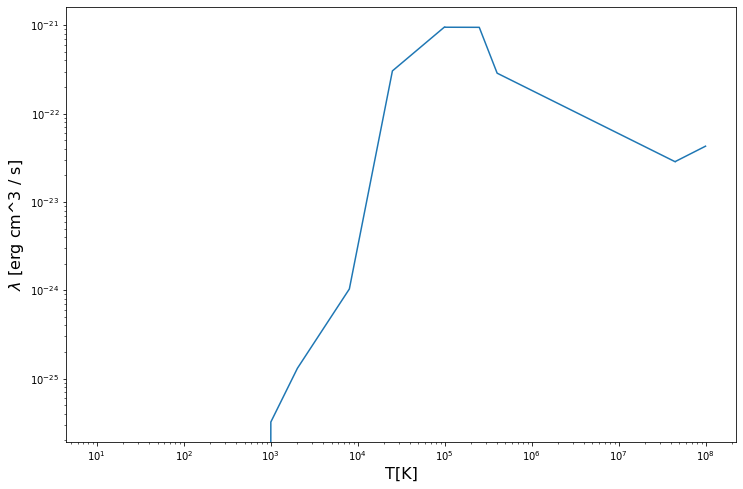

In [19]:
N=100000
fs=16
temp = np.logspace(1,8,num=N)
lamb = np.zeros(N)
for i,t in enumerate(temp):
    lamb[i] = cooling(t)
plt.figure(figsize=(12,8))
plt.loglog(temp,lamb)
plt.xlabel('T[K]', fontsize=fs)
plt.ylabel(r'$\lambda$ [erg cm^3 / s]', fontsize=fs);

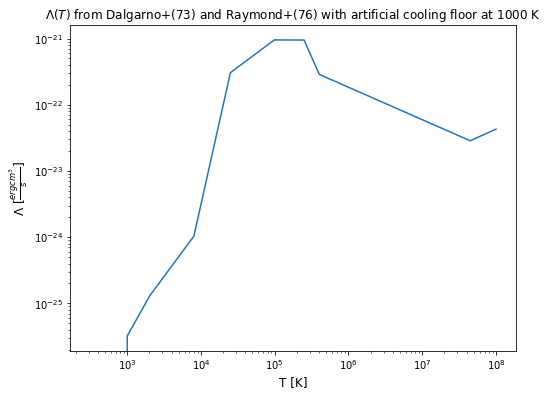

In [20]:
#veryfying that the grid and loop version are the same
fs=12
temp = np.logspace(2.5,8,num=N)
lamb = cooling_grid(temp)
plt.figure(figsize=(8,6))
plt.loglog(temp,lamb)
plt.xlabel('T [K]', fontsize=fs)
plt.ylabel(r'$\Lambda$ [$\frac{erg cm^3}{s}$]', fontsize=fs);
plt.title(r"$\Lambda(T)$ from Dalgarno+(73) and Raymond+(76) with artificial cooling floor at 1000 K", fontsize=fs)
plt.savefig('figs/cooling_DR.png')

## Trying to implement some cooling function.

Note that not all densities are created equal and need a factor of 1/ds^3 to be correct

t=0 P=10839.373188685457 M=3125000.0 E=1.179685203394868 it=0
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 0.21024101492920935


KeyboardInterrupt: 

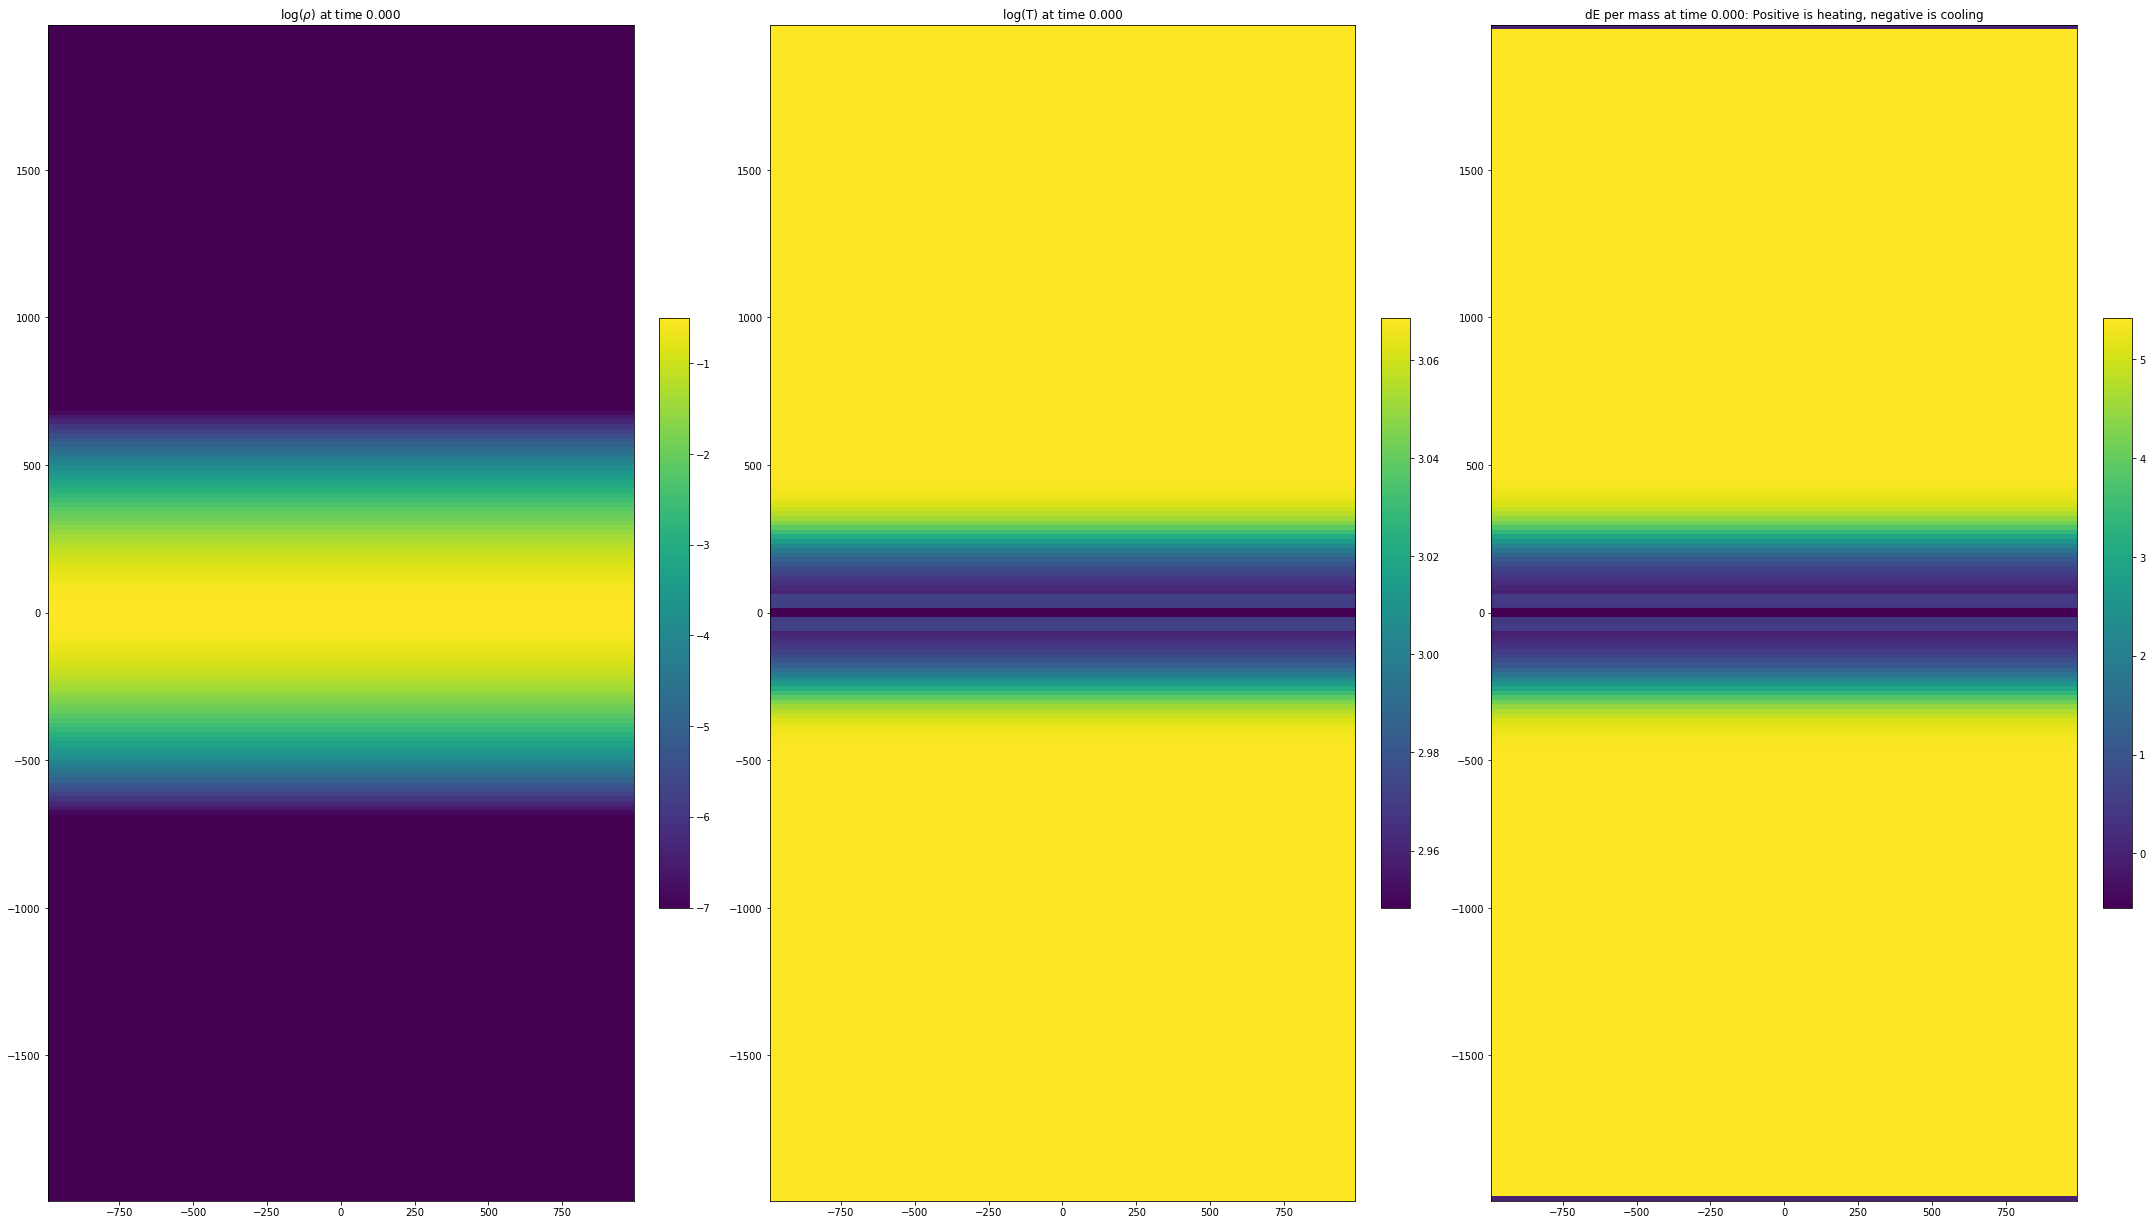

In [21]:
Lbox = 2e3
n = 128
Cdt = 0.01
nt = 100000
totalSN=0
u = initial_condition(n=n, Lbox=Lbox, ratio=2)
start = time()
it=0
t_total=20
stop_SN=10
dt_plot = 2
t_plot = 0
dt_SN = 0.2
t_SN = 0.
while u.t < t_total and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt, do_cooling=1)
# Boundary conditions at upper and lower end of box:
    rho_out_up =np.mean(u.rho[:,2:4])
    rho_out_down=np.mean(u.rho[:,-4:-2])
    P_out_up   =np.mean(u.pressure()[:,2:4])
    P_out_down = np.mean(u.pressure()[:,-4:-2])
    u.rho[:,0] = rho_out_up
    u.rho[:,-1] = rho_out_down
    u.Px[:,0] = u.Px[:,-1] = 0
    u.Py[:,0] = u.Py[:,-1] = 0
    u.Etot[:,0] =P_out_up / (u.gamma - 1.)
    u.Etot[:,-1] = P_out_down / (u.gamma - 1.)

    if (u.t - t_plot > dt_plot or u.t==0):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label=''
        print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
        plotrhoTcool(u, size=30)
        t_plot += dt_plot
#         imshow(np.log10(T_units(u)))
    #supernovae for a while and then just cooling
    if (u.t - t_SN > dt_SN and u.t<stop_SN):
        blast_wave_units(u,E=1e44,mass=10,power=2,w=1., verbose=1)
        t_SN += dt_SN
        totalSN+=1
    if u.t>stop_SN:
        Cdt=0.1
    u.t += dt
    it+=1
plotrhoTcool(u, size=30)
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
print(f"Total SNe detonated {totalSN}")

In [ ]:
print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))

In [ ]:
makegif=0
if makegif:
    import matplotlib
    matplotlib.use("Agg")
    import matplotlib.animation as anim

    class AnimatedGif:
        def __init__(self, size=(640, 480)):
            self.fig = plt.figure()
            self.fig.set_size_inches(size[0] / 100, size[1] / 100)
            ax = self.fig.add_axes([0, 0, 1, 1], frameon=False, aspect=1)
            ax.set_xticks([])
            ax.set_yticks([])
            self.images = []

        def add(self, image, label=''):
            plt_im = plt.imshow(image, cmap='magma', vmin=0, vmax=1, animated=True)
            plt_txt = plt.text(0.1, 0.7,label, fontsize=10, color='white')
            self.images.append([plt_im, plt_txt])

        def save(self, filename):
            im_ani = anim.ArtistAnimation(self.fig, self.images)
            Writer = anim.writers['pillow'] # for .gif
    #         Writer = anim.writers['html'] # for .html, do not use
            writer = Writer(fps=4, bitrate=1800)
            im_ani.save(filename, writer=writer)


    Lbox = 2e3
    n = 128
    Cdt = 0.5
    nt = 100000
    totalSN=0
    u = initial_condition(n=n, Lbox=Lbox)
    u.rho_out = u.rho[0,0]
    u.P_out = (u.pressure())[0,0]
    start = time()
    it=0
    dt_plot = 0.1
    t_plot = 0.
    dt_SN = 0.2
    t_SN = 0.

    m = 480*2
    n = 320*2
    animated_gif = AnimatedGif(size=(m, n))
    animated_gif.add(u.rho.T, label=f'{u.t}')
    images = []

    print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
    while u.t < 200 and it < nt:
        dt=u.Courant(Cdt)
        u = muscl_2d(u,dt, do_cooling=1)
    # Boundary conditions at upper and lower end of box:
        rho_out_up =np.mean(u.rho[:,2:4])
        rho_out_down=np.mean(u.rho[:,-4:-2])
        P_out_up   =np.mean(u.pressure()[:,2:4])
        P_out_down = np.mean(u.pressure()[:,-4:-2])
        u.rho[:,0] = rho_out_up
        u.rho[:,-1] = rho_out_down
        u.Px[:,0] = u.Px[:,-1] = 0
        u.Py[:,0] = u.Py[:,-1] = 0
        u.Etot[:,0] =P_out_up / (u.gamma - 1.)
        u.Etot[:,-1] = P_out_down / (u.gamma - 1.)
        #plt.figure()
        if (u.t - t_plot > dt_plot):
            #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
            #plt.plot(u.y,np.mean(u.rho,axis=0),label=''
#             print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
    #         plotrhoT(u)
            t_plot += dt_plot
            animated_gif.add(u.rho.T, label=f'{u.t} Myr')
        #supernovae for a while and then just cooling
        if (u.t - t_SN > dt_SN and u.t<10):
            blast_wave_units(u,E=1e44,mass=10,power=2,w=1., verbose=0)
            t_SN += dt_SN
            totalSN+=1
        u.t += dt
        it+=1
    # plotrhoT(u)
    used=time()-start
    print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
    print("t={} nt={}".format(u.t,it))
    print(f"Total SNe detonated {totalSN}")



    # filename
    animated_gif.save('mov/SN_cooling_rho.gif')
    print('Made gif')

In [ ]:
#Standard dwarf-like galaxy
Lbox = 1e3
n = 128
Cdt = 0.001
nt = 100000
cool=1
ratio=3
verbose=1
totalSN=0
massfact=1 # MW
u = initial_condition(n=n, ratio=ratio, Lbox=Lbox, R0 = 8000*((massfact))**(1/3), Mvir=1.3e12/massfact)
start = time()
it=0
# plt.figure(figsize=(16,10))
# plt.plot(u.y,u.rho[0],label='rho0')
# plt.legend()
# plt.title('Initial density configuration')
dt_plot = 5
t_plot = 0.
dt_SN = 0.2*massfact # to get a realistic picture
t_SN = 0.
ts=[0]
print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
while u.t < 20 and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt, do_cooling=cool)
#     u.rho+=1e-50 #keep everything stable
# Boundary conditions at upper and lower end of box:
    rho_out_up =np.mean(u.rho[:,2:4])
    rho_out_down=np.mean(u.rho[:,-4:-2])
    P_out_up   =np.mean(u.pressure()[:,2:4])
    P_out_down = np.mean(u.pressure()[:,-4:-2])
    u.rho[:,0] = rho_out_up
    u.rho[:,-1] = rho_out_down
    u.Px[:,0] = u.Px[:,-1] = 0
    u.Py[:,0] = u.Py[:,-1] = 0
    u.Etot[:,0] =P_out_up / (u.gamma - 1.)
    u.Etot[:,-1] = P_out_down / (u.gamma - 1.)
    #plt.figure()
    if (u.t - t_plot > dt_plot):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
        print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
        if cool:
            plotrhoTcool(u)
        else:
            plotrhoT(u)
        t_plot += dt_plot
    if (u.t - t_SN > dt_SN and u.t<10):
#         blast_wave(u,e0=1e4,d0=1,power=2,w=3.)
        blast_wave_units(u,E=1e44,mass=10, w=1, verbose=verbose)
        t_SN += dt_SN
        totalSN+=1
    u.t += dt
    ts.append(np.copy(u.t))
    it+=1
if cool:
    plotrhoTcool(u)
else:
    plotrhoT(u)
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
print(f"Total SNe detonated {totalSN}")

In [ ]:
#Standard dwarf-like galaxy
Lbox = 1e3
n = 128
Cdt = 0.01 # if cool then set this down quite a lot!
nt = 100000
cool=1
ratio=3
verbose=1
totalSN=0
massfact=10 # a dwarf galaxy with a halo about 10 times less massive than the MW, with R0 adjusted accordingly
u = initial_condition(n=n, ratio=ratio, Lbox=Lbox, R0 = 8000*((massfact))**(1/3), Mvir=1.3e12/massfact)
start = time()
it=0
# plt.figure(figsize=(16,10))
# plt.plot(u.y,u.rho[0],label='rho0')
# plt.legend()
# plt.title('Initial density configuration')
dt_plot = 5
t_plot = 0.
dt_SN = 0.2*massfact # to get a realistic picture
t_SN = 0.
ts=[0]
print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
while u.t < 20 and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt, do_cooling=cool)
#     u.rho+=1e-50 #keep everything stable
# Boundary conditions at upper and lower end of box:
    rho_out_up =np.mean(u.rho[:,2:4])
    rho_out_down=np.mean(u.rho[:,-4:-2])
    P_out_up   =np.mean(u.pressure()[:,2:4])
    P_out_down = np.mean(u.pressure()[:,-4:-2])
    u.rho[:,0] = rho_out_up
    u.rho[:,-1] = rho_out_down
    u.Px[:,0] = u.Px[:,-1] = 0
    u.Py[:,0] = u.Py[:,-1] = 0
    u.Etot[:,0] =P_out_up / (u.gamma - 1.)
    u.Etot[:,-1] = P_out_down / (u.gamma - 1.)
    #plt.figure()
    if (u.t - t_plot > dt_plot):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
        print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
        if cool:
            plotrhoTcool(u)
        else:
            plotrhoT(u)
        t_plot += dt_plot
    if (u.t - t_SN > dt_SN and u.t<10):
#         blast_wave(u,e0=1e4,d0=1,power=2,w=3.)
        blast_wave_units(u,E=1e44,mass=10, w=1, verbose=verbose)
        t_SN += dt_SN
        totalSN+=1
    u.t += dt
    ts.append(np.copy(u.t))
    it+=1
if cool:
    plotrhoTcool(u)
else:
    plotrhoT(u)
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
print(f"Total SNe detonated {totalSN}")

## Measuring outflow (for a set of different galaxy types)

In [ ]:
#Standard dwarf-like galaxy
Lbox = 1e3
n = 128
Cdt = 0.5 # if cool then set this down quite a lot!
nt = 100000
cool=0
cut=1000
ratio=3
verbose=1
totalSN=0
massfact=10 # a dwarf galaxy with a halo about 10 times less massive than the MW, with R0 adjusted accordingly
it=0
dt_plot = 5
t_plot = 0.
# dt_SN = 0.2*massfact # to get a realistic picture
dt_SN=0.2
t_SN=0
if (ratio*cut<Lbox):
    sys.exit()
u = initial_condition(n=n, ratio=ratio, Lbox=Lbox)
start = time()
rho_out=u.rho[0,0]
P_out=u.pressure()[0,0]
cut=np.abs(np.argmin(np.abs(cut-u.y)))
mass=[np.copy(np.sum(u.rho)*u.ds**3)]
p_up=[np.copy(np.sum(u.Py[:,cut])*u.ds**3)]
p_down=[np.copy(np.sum(-u.Py[:,-cut])*u.ds**3)]
ts=[0]
print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
while u.t < 30 and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt, do_cooling=cool)
#     u.rho+=1e-50 #keep everything stable
# Boundary conditions at upper and lower end of box:
    u.rho[:,0] = u.rho[:,-1] = rho_out
    u.Px[:,0] = u.Px[:,-1] = 0
    u.Py[:,0] = u.Py[:,-1] = 0
    u.Etot[:,0] =P_out / (u.gamma - 1.)
    u.Etot[:,-1] = P_out/ (u.gamma - 1.)
    #plt.figure()
    if (u.t - t_plot > dt_plot):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
        print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
        if cool:
            plotrhoTcool(u)
        else:
            plotrhoT(u)
        t_plot += dt_plot
    if (u.t - t_SN > dt_SN):
#         blast_wave(u,e0=1e4,d0=1,power=2,w=3.)
        blast_wave_units(u,E=1e44,mass=10, w=1, verbose=True)
        t_SN += dt_SN
        totalSN+=1
    gas_mass=np.copy(np.sum(u.rho)*u.ds**3)-totalSN*10
    mass.append(gas_mass)
    p_up.append(np.copy(np.sum(u.Py[:,cut])*u.ds**3))
    p_down.append(np.copy(np.sum(-u.Py[:,-cut])*u.ds**3))
    u.t += dt
    ts.append(np.copy(u.t))
    it+=1
mass=np.array(mass)
ts=np.array(ts)
p_up=np.array(p_up)
p_down=np.array(p_down)
p=p_up+p_down
if cool:
    plotrhoTcool(u)
else:
    plotrhoT(u)
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
print(f"Total SNe detonated {totalSN}")

In [ ]:
mass_lost(np.array(mass),np.array(ts), scale='log',scenario='dwarf_nocool_samerate')

In [ ]:
momentum_flow(p_up,p_down, p, ts, cut=cut, scale='log',scenario='dwarf_nocool_samerate')

In [ ]:
#Standard MW-like 
Lbox = 1e3
n = 128
Cdt = 0.5 # if cool then set this down quite a lot!
nt = 100000
cool=0
cut=1000
ratio=3
verbose=1
totalSN=0
massfact=1 # a dwarf galaxy with a halo about 10 times less massive than the MW, with R0 adjusted accordingly
it=0
dt_plot = 5
t_plot = 0.
dt_SN = 0.2*massfact # to get a realistic picture
t_SN=0
if (ratio*cut<Lbox):
    sys.exit()
u = initial_condition(n=n, ratio=ratio, Lbox=Lbox)
start = time()

cut=np.abs(np.argmin(np.abs(cut-u.y)))
mass=[np.copy(np.sum(u.rho)*u.ds**3)]
p_up=[np.copy(np.sum(u.Py[:,cut])*u.ds**3)]
p_down=[np.copy(np.sum(-u.Py[:,-cut])*u.ds**3)]
ts=[0]
print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
while u.t < 30 and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt, do_cooling=cool)
#     u.rho+=1e-50 #keep everything stable
# Boundary conditions at upper and lower end of box:
    rho_out_up =np.mean(u.rho[:,2:4])
    rho_out_down=np.mean(u.rho[:,-4:-2])
    P_out_up   =np.mean(u.pressure()[:,2:4])
    P_out_down = np.mean(u.pressure()[:,-4:-2])
    u.rho[:,0] = rho_out_up
    u.rho[:,-1] = rho_out_down
    u.Px[:,0] = u.Px[:,-1] = 0
    u.Py[:,0] = u.Py[:,-1] = 0
    u.Etot[:,0] =P_out_up / (u.gamma - 1.)
    u.Etot[:,-1] = P_out_down / (u.gamma - 1.)
    #plt.figure()
    if (u.t - t_plot > dt_plot):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
        print("t={} P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
        if cool:
            plotrhoTcool(u)
        else:
            plotrhoT(u)
        t_plot += dt_plot
    if (u.t - t_SN > dt_SN):
#         blast_wave(u,e0=1e4,d0=1,power=2,w=3.)
        blast_wave_units(u,E=1e44,mass=10, w=1, verbose=True)
        t_SN += dt_SN
        totalSN+=1
    gas_mass=np.copy(np.sum(u.rho)*u.ds**3)-totalSN*10
    mass.append(gas_mass)
    p_up.append(np.copy(np.sum(u.Py[:,cut])*u.ds**3))
    p_down.append(np.copy(np.sum(-u.Py[:,-cut])*u.ds**3))
    u.t += dt
    ts.append(np.copy(u.t))
    it+=1
mass=np.array(mass)
ts=np.array(ts)
p_up=np.array(p_up)
p_down=np.array(p_down)
p=p_up+p_down
if cool:
    plotrhoTcool(u)
else:
    plotrhoT(u)
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
print(f"Total SNe detonated {totalSN}")

In [ ]:
mass_lost(np.array(mass),np.array(ts), scale='log',scenario='MW_nocool')

In [ ]:
momentum_flow(p_up,p_down, p, ts, cut=cut, scale='log',scenario='MW_nocool')

## Adding star formation

In [26]:
#Standard MW-like 
scenario='MW_nocool'
Lbox = 1e3
ratio=3
mass_low=0.5
n = 64
Cdt = 0.2 # if cool then set this down quite a lot!
nt = 100000
total_t=20
stopSN=5
cool=0
cut=1000
verbose=1
SF=1
totalSN=0
massfact=1 # a dwarf galaxy with a halo about 10 times less massive than the MW, with R0 adjusted accordingly
it=0
dt_plot = 4
t_plot = 0.
dt_SN = 0.2*massfact # to get a realistic picture
t_SN=0
makemovie=0
t_movie=0
dt_movie=0.1
n_SN=np.zeros(nt)
if (ratio*cut<Lbox):
    sys.exit()
u = initial_condition(n=n, ratio=ratio, Lbox=Lbox)
rho_out=u.rho[0,0]
P_out=u.pressure()[0,0]
m, spec=make_IMF()
start = time()
nstars=[]
stars=np.zeros(np.shape(u.rho))
cut=np.abs(np.argmin(np.abs(cut-u.y)))
mass=[np.copy(np.sum(u.rho)*u.ds**3)]
p_up=[np.copy(np.sum(u.Py[:,cut])*u.ds**3)]
p_down=[np.copy(np.sum(-u.Py[:,-cut])*u.ds**3)]
ts=[0]
print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
while u.t < total_t and it < nt:
    dt=u.Courant(Cdt)
    u = muscl_2d(u,dt, do_cooling=cool)
#     u.rho+=1e-50 #keep everything stable
# Boundary conditions at upper and lower end of box:
    u.rho[:,0] = u.rho[:,-1] = rho_out
    u.Px[:,0] = u.Px[:,-1] = 0
    u.Py[:,0] = u.Py[:,-1] = 0
    u.Etot[:,0] =P_out / (u.gamma - 1.)
    u.Etot[:,-1] = P_out/ (u.gamma - 1.)
    #plt.figure()
    if SF:
        stars0=np.copy(stars)
        stars=np.where(mass_low<u.rho,np.random.choice(m, p=spec, size=np.shape(stars0)),stars0) #select stars from Chabrier IMF if gas cloud if more than density, if not return current state
        starcheck=stars-stars0
        starsT=np.where(u.temperature_cgs()<1e4,starcheck,0) #overturn choice if too hot (1000 K)
        u.rho-=starsT/u.ds**3
        stars=stars0+starsT
        nstars.append(np.sum(stars))
    if (u.t - t_plot > dt_plot):
        #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
        #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
        print("t={} P={} M={} E={} it={}, m_stars={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it, nstars[it]))
        if not makemovie:
            plotall(u,totalSN,mass,stars,scenario=None)
        t_plot += dt_plot
    if (u.t - t_SN > dt_SN and u.t<stopSN):
        blast_wave_units(u,E=1e44,mass=10, w=1, verbose=verbose)
        t_SN += dt_SN
        totalSN+=1
    n_SN[it]=totalSN
    if SF:
        gas_mass=np.copy(np.sum(u.rho)*u.ds**3)-totalSN*10+np.sum(stars)
    else:
        gas_mass=np.copy(np.sum(u.rho)*u.ds**3)-totalSN*10
        print('sthap')
    mass.append(gas_mass)
    p_up.append(np.copy(np.sum(u.Py[:,cut])*u.ds**3))
    p_down.append(np.copy(np.sum(-u.Py[:,-cut])*u.ds**3))
    u.t += dt
    ts.append(np.copy(u.t))
    it+=1
    if verbose==2:
        if it%100==0:
            print(it,u.t)
    if makemovie:
        if u.t-t_movie>dt_movie:
            scenario1=str(it).zfill(int(np.log10(nt)+1))+scenario
            plotall(u,totalSN,mass,stars,scenario=scenario1)
            plt.close('all')
            t_movie+=dt_movie
mass=np.array(mass)
ts=np.array(ts)
p_up=np.array(p_up)
p_down=np.array(p_down)
plotall(u,totalSN, mass,stars,scenario=scenario)
used=time()-start
print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
print("t={} nt={}".format(u.t,it))
print(f"Total SNe detonated {totalSN}")
mass_lost(np.array(mass),np.array(ts), scale='log',scenario=scenario)
momentum_flow(p_up,p_down, ts, cut=cut, scale='log',scenario=scenario)
if star_formation:
    #what we see here is that if too many SN, then no SF
    plot_SF(ts, nstars, n_SN,scenario=scenario)

Initial conditions: P=0 M=5256.10136608405 E=1562500.0000000002 it=0.5720389250731579
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 0.6757308624309597
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 1.265383170843593
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 1.295279294389259
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 1.3181324394735463
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 1.3413778594438321
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.0008346029323979383, e0: 4388.028035741, at time 1.365286175474428
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 0.000834602932

KeyboardInterrupt: 

In [ ]:
#what we see here is that if too many SN, then no SF
plt.plot(ts[1:], nstars)
plt.plot(ts[1:], 10*n_SN[:it])

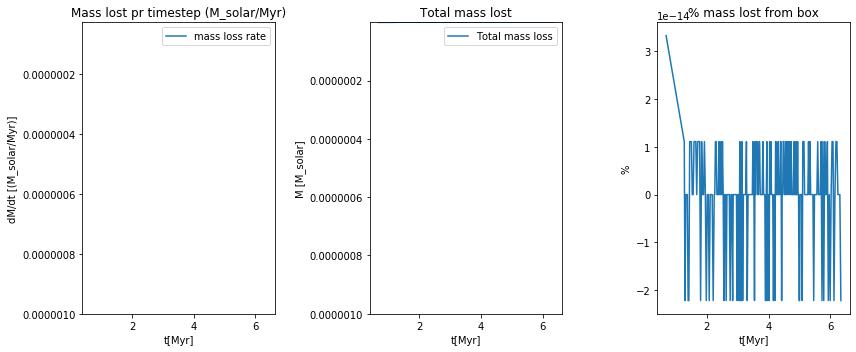

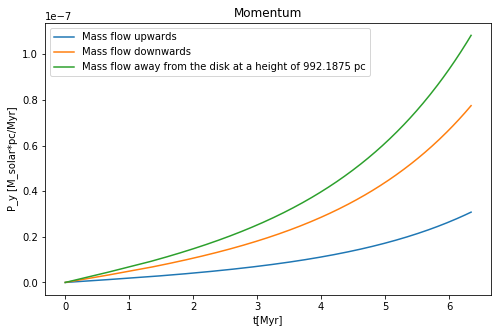

In [110]:
mass_lost(np.array(mass),np.array(ts), scale='linear',scenario=scenario)
momentum_flow(p_up,p_down, ts, cut=cut, scale='linear',scenario=scenario)

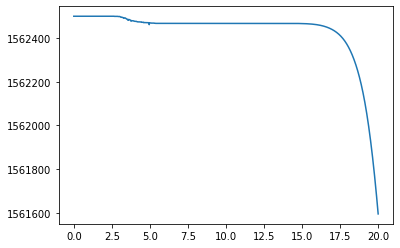

In [81]:
plt.plot(ts,mass)

In [27]:
rho_out

1.05035054408241e-31

Still to do: 


Try different mass outflow experiments.

Add random noise to the SN 

In [29]:
#Standard MW-like 
def run_experiment(scenario, Cdt, cool, SF,dt_plot = 4, makemovie=0, dt_movie=0.1,\
                   massfact=1, total_t=20, stopSN=None, verbose=1, dt_SN=0.2, n=128,\
                   cut=1000, ratio=3, Lbox=1e3,mass_low=0.5, nt=100000):
    scenario+=f'_cool{cool}'
    scenario+=f'_n{n}'
    if stopSN==None:
        stopSN=total_t
    totalSN=0 # a dwarf galaxy with a halo about 10 times less massive than the MW, with R0 adjusted accordingly
    it=0
    t_plot = 0.# to get a realistic picture
    t_SN=0
    makemovie=0
    t_movie=0
    n_SN=np.zeros(nt)

    u = initial_condition(n=n, ratio=ratio, Lbox=Lbox)
    rho_out=u.rho[0,0]
    P_out=u.pressure()[0,0]
    m, spec=make_IMF()
    start = time()
    nstars=[]
    stars=np.zeros(np.shape(u.rho))
    cut=np.abs(np.argmin(np.abs(cut-u.y)))
    mass=[np.copy(np.sum(u.rho)*u.ds**3)]
    p_up=[np.copy(np.sum(u.Py[:,cut])*u.ds**3)]
    p_down=[np.copy(np.sum(-u.Py[:,-cut])*u.ds**3)]
    ts=[0]
    print("Initial conditions: P={} M={} E={} it={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it))
    while u.t < total_t and it < nt:
        dt=u.Courant(Cdt)
        u = muscl_2d(u,dt, do_cooling=cool)
    #     u.rho+=1e-50 #keep everything stable
    # Boundary conditions at upper and lower end of box:
        u.rho[:,0] = u.rho[:,-1] = rho_out
        u.Px[:,0] = u.Px[:,-1] = 0
        u.Py[:,0] = u.Py[:,-1] = 0
        u.Etot[:,0] =P_out / (u.gamma - 1.)
        u.Etot[:,-1] = P_out/ (u.gamma - 1.)
        #plt.figure()
        if SF:
            stars0=np.copy(stars)
            stars=np.where(mass_low<u.rho,np.random.choice(m, p=spec, size=np.shape(stars0)),stars0) #select stars from Chabrier IMF if gas cloud if more than density, if not return current state
            starcheck=stars-stars0
            starsT=np.where(u.temperature_cgs()<1e4,starcheck,0) #overturn choice if too hot (1000 K)
            u.rho-=starsT/u.ds**3
            stars=stars0+starsT
            nstars.append(np.sum(stars))
        if (u.t - t_plot > dt_plot):
            #plt.plot(u.y,np.mean(u.Py,axis=0),label='t = {}'.format(u.t))
            #plt.plot(u.y,np.mean(u.rho,axis=0),label='')
            print("t={} P={} M={} E={} it={}, m_stars={}".format(u.t,np.sum(u.pressure()),np.sum(u.rho)*u.ds**3,(np.sum(u.Etot)*u.ds**3*1.902e36/1e44), it, nstars[it]))
            if not makemovie:
                plotall(u,totalSN,mass,stars,scenario=None)
            t_plot += dt_plot
        if (u.t - t_SN > dt_SN and u.t<stopSN):
            blast_wave_units(u,E=1e44,mass=10, w=3, verbose=verbose)
            t_SN += dt_SN
            totalSN+=1
        n_SN[it]=totalSN
        if SF:
            gas_mass=np.copy(np.sum(u.rho)*u.ds**3)-totalSN*10+np.sum(stars)
        else:
            gas_mass=np.copy(np.sum(u.rho)*u.ds**3)-totalSN*10
        mass.append(gas_mass)
        p_up.append(np.copy(np.sum(u.Py[:,cut])*u.ds**3))
        p_down.append(np.copy(np.sum(-u.Py[:,-cut])*u.ds**3))
        u.t += dt
        ts.append(np.copy(u.t))
        it+=1
        if verbose==2:
            if it%100==0:
                print(f'iteration: {it},time:{u.t}')
        if makemovie:
            if u.t-t_movie>dt_movie:
                scenario1=str(it).zfill(int(np.log10(nt)+1))+scenario
                plotall(u,totalSN,mass,stars,scenario=scenario1)
                plt.close('all')
                t_movie+=dt_movie
    mass=np.array(mass)
    ts=np.array(ts)
    p_up=np.array(p_up)
    p_down=np.array(p_down)
    plotall(u,totalSN, mass,stars,scenario=scenario)
    used=time()-start
    print('{:.1f} sec, {:.2f} microseconds/update'.format(used,1e6*used/(n**2*it)))
    print("t={} nt={}".format(u.t,it))
    print(f"Total SNe detonated {totalSN}")
    mass_lost(np.array(mass),np.array(ts), scale='log',scenario=scenario)
    momentum_flow(p_up,p_down, ts, cut=cut, scale='log',scenario=scenario)
    if SF:
        #what we see here is that if too many SN, then no SF
        plot_SF(ts, nstars, n_SN,it,scenario=scenario)
    return u, mass, stars, totalSN

Initial conditions: P=0 M=10512.202732168078 E=3124999.999999994 it=1.1440778501463134
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 9.271447422640402e-05, e0: 487.4578035037015, at time 0.2035886683234622
Subcycling : 6 0.000488178940413128
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 9.271447422640402e-05, e0: 487.4578035037015, at time 0.40478014264005585
Subcycling : 6 0.0006372741329051532
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 9.271447422640402e-05, e0: 487.4578035037015, at time 0.6056168886742382
Subcycling : 6 0.0006283510824267771
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 9.271447422640402e-05, e0: 487.4578035037015, at time 0.8024693350094396
Subcycling : 6 0.0006369458600594835
Added supernova with mass: 10 solar masses, log(energy J): 44.0: d0: 9.271447422640402e-05, e0: 487.4578035037015, at time 1.004633643436241
Subcycling : 6 0.00061339736440068
Added supernova with 

FloatingPointError: invalid value encountered in sqrt

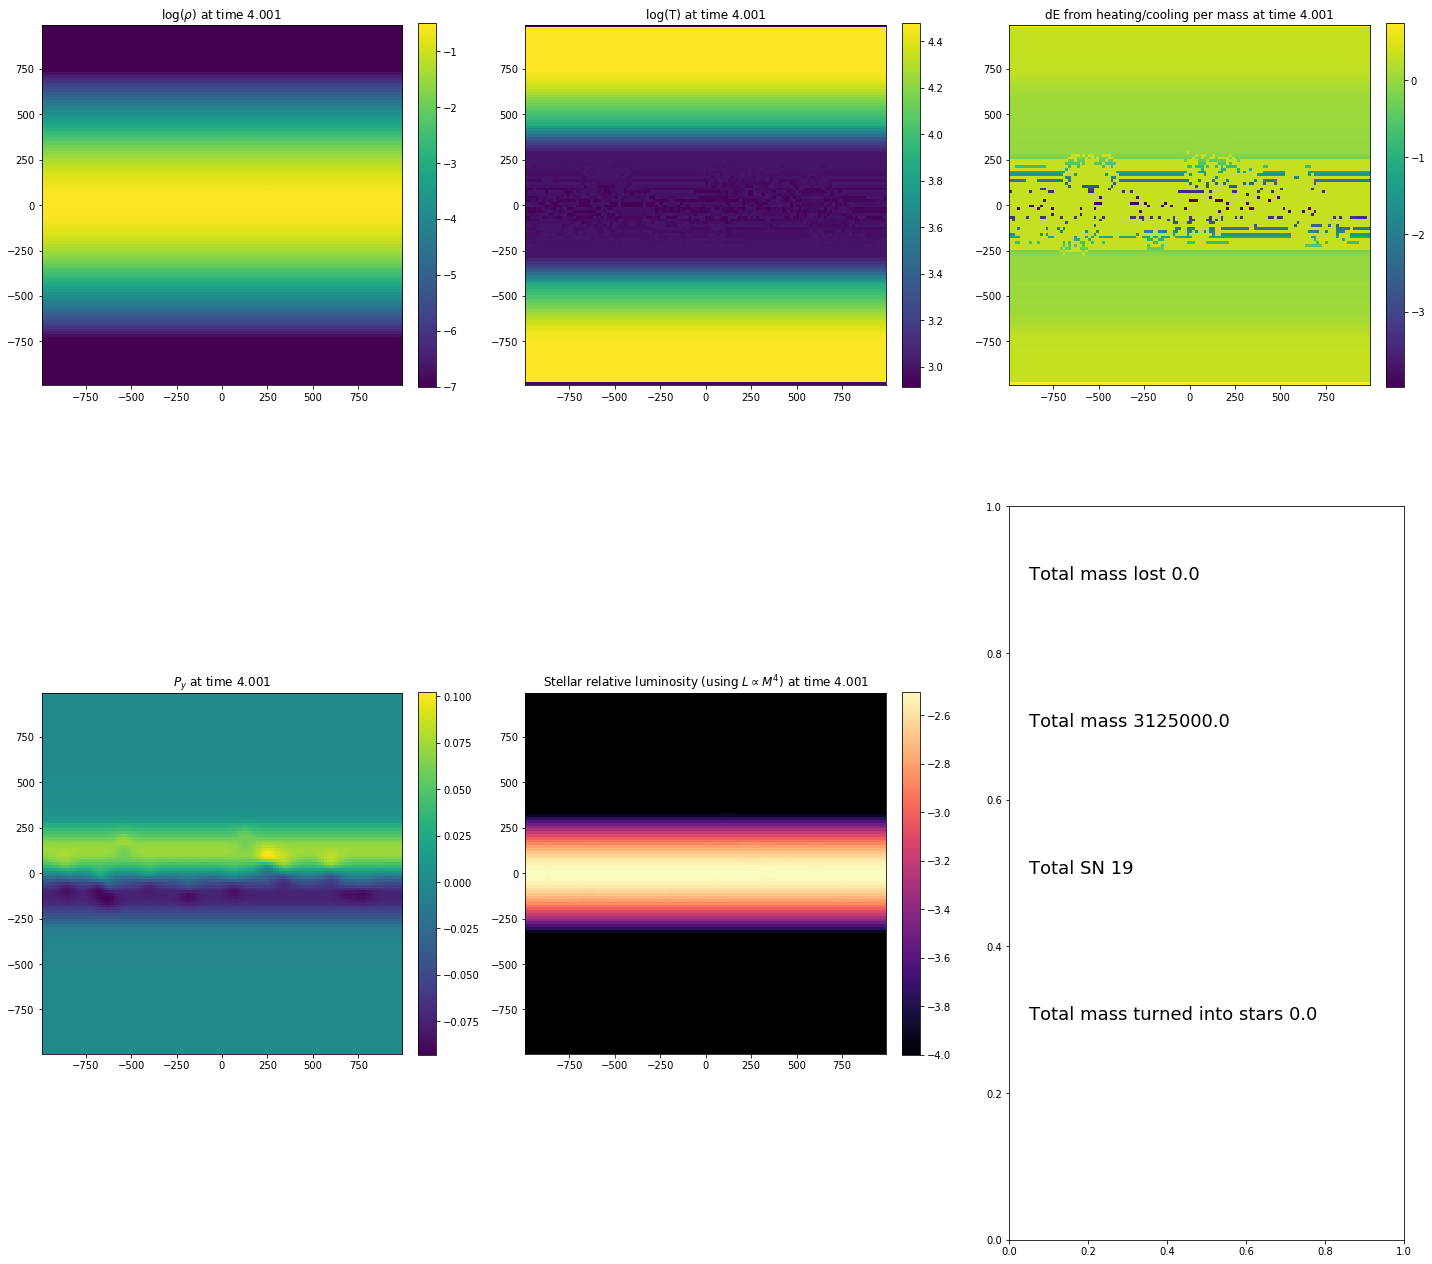

In [35]:
u, mass, stars, total_SN=run_experiment(scenario='MW', Cdt=0.1, Lbox=2e3, cool=1, SF=1, n=128, ratio=1, verbose=1)

In [40]:
np.min(u.rho), np.min(u.pressure())

NameError: name 'u' is not defined